# Predcition of Hospital Admission Related to Lower Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to lower respiratory tract infection (lrti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 
                           'lrti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [18]:
#build cox models stratified with antibiotics history categories
def cox_model_strat_ab_hist_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [19]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')

In [20]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [21]:
#process 20 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)
data_lrti_13 = proc_infec_data(data,13)
data_lrti_14 = proc_infec_data(data,14)
data_lrti_15 = proc_infec_data(data,15)
data_lrti_16 = proc_infec_data(data,16)
data_lrti_17 = proc_infec_data(data,17)
data_lrti_18 = proc_infec_data(data,18)
data_lrti_19 = proc_infec_data(data,19)
data_lrti_20 = proc_infec_data(data,20)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12, data_lrti_13, data_lrti_14, data_lrti_15, data_lrti_16, data_lrti_17, data_lrti_18, data_lrti_19, data_lrti_20])
data_lrti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [22]:
##add variable season
#convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] 
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

In [23]:
#add variable time period
data_lrti.loc[(data_lrti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_lrti.loc[((data_lrti['date'] >= '2020-01') & (data_lrti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_lrti.loc[(data_lrti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [24]:
#scenario 1
#not hosped (nothing happened)
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0

In [25]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]

In [26]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [27]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30

#give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

In [28]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [29]:
#drop anybody with age less than 18 or 0!
data_lrti = data_lrti[~(data_lrti['age'] < 18)] 
data_lrti['age'][data_lrti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

In [30]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking": dict_smoking})

In [31]:
#drop rows with missing region
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
   data_lrti = data_lrti[data_lrti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_lrti.columns) and (data_lrti['smoking'].isnull().sum() > 0):
    data_lrti['smoking'] = data_lrti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

In [32]:
#missing values of bmi assign 5 and 0; categorise bmi
data_lrti['bmi_cat'] = 5

for idx, x in enumerate(data_lrti['bmi_cat']):
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 30:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 25) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 30):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 18.5) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 25):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 18.5:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

In [33]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])
#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [34]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [35]:
#categorise CCI
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)
#categorise CCI
data_lrti['antibacterial_brit_cat'] = pd.cut(data_lrti['antibacterial_brit'], right=False, bins=[0,1,3,6,10,1000], labels=['none0', 'low1_2', 'medium3_5', 'high6_9', 'very_high10_more'])
data_lrti['antibacterial_brit_cat'].value_counts()

none0               93378
medium3_5           45819
low1_2              43510
high6_9                 0
very_high10_more        0
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

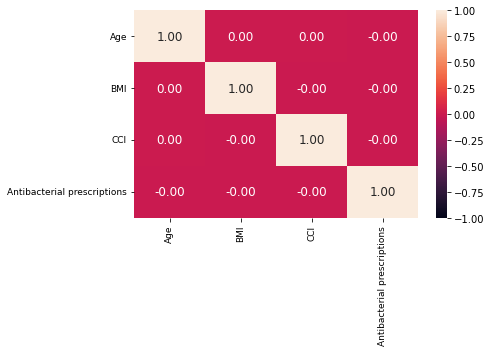

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [37]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                       'antibacterial_brit', 'antibacterial_brit_cat', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date', 'period',
                       'event_lrti_admitted', 'duration_lrti_admitted'
                       ]]

In [38]:
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]
#switch variable lrti_ab_date into a binary variable
data_lrti_incdt[['lrti_ab_date']] = data_lrti_incdt[['lrti_ab_date']].where(data_lrti_incdt[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_lrti_prevl[['lrti_ab_date']] = data_lrti_prevl[['lrti_ab_date']].where(data_lrti_prevl[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_lrti_incdt_males = data_lrti_incdt[data_lrti_incdt['sex'] == 'male']
data_lrti_incdt_females = data_lrti_incdt[data_lrti_incdt['sex'] == 'female']
data_lrti_prevl_males = data_lrti_prevl[data_lrti_prevl['sex'] == 'male']
data_lrti_prevl_females = data_lrti_prevl[data_lrti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by antibiotics history categories
data_lrti_incdt_none0 = data_lrti_incdt[data_lrti_incdt['antibacterial_brit_cat'] == 'none0']
data_lrti_incdt_low1_2 = data_lrti_incdt[data_lrti_incdt['antibacterial_brit_cat'] == 'low1_2']
data_lrti_incdt_medium3_5 = data_lrti_incdt[data_lrti_incdt['antibacterial_brit_cat'] == 'medium3_5']
data_lrti_incdt_high6_9 = data_lrti_incdt[data_lrti_incdt['antibacterial_brit_cat'] == 'high6_9']
data_lrti_incdt_very_high10_more = data_lrti_incdt[data_lrti_incdt['antibacterial_brit_cat'] == 'very_high10_more']
data_lrti_prevl_none0 = data_lrti_prevl[data_lrti_prevl['antibacterial_brit_cat'] == 'none0']
data_lrti_prevl_low1_2 = data_lrti_prevl[data_lrti_prevl['antibacterial_brit_cat'] == 'low1_2']
data_lrti_prevl_medium3_5 = data_lrti_prevl[data_lrti_prevl['antibacterial_brit_cat'] == 'medium3_5']
data_lrti_prevl_high6_9 = data_lrti_prevl[data_lrti_prevl['antibacterial_brit_cat'] == 'high6_9']
data_lrti_prevl_very_high10_more = data_lrti_prevl[data_lrti_prevl['antibacterial_brit_cat'] == 'very_high10_more']

#incident and prevalent infection stratified by age categories
data_lrti_incdt_15_24 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '15_24']
data_lrti_incdt_25_34 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '25_34']
data_lrti_incdt_35_44 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '35_44']
data_lrti_incdt_45_54 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '45_54']
data_lrti_incdt_55_64 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '55_64']
data_lrti_incdt_65_74 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '65_74']
data_lrti_incdt_75_more = data_lrti_incdt[data_lrti_incdt['age_cat'] == '75_more']
data_lrti_prevl_15_24 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '15_24']
data_lrti_prevl_25_34 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '25_34']
data_lrti_prevl_35_44 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '35_44']
data_lrti_prevl_45_54 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '45_54']
data_lrti_prevl_55_64 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '55_64']
data_lrti_prevl_65_74 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '65_74']
data_lrti_prevl_75_more = data_lrti_prevl[data_lrti_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_lrti_incdt_prepandemic = data_lrti_incdt[data_lrti_incdt['date'] <= '2019-12']
data_lrti_incdt_during_pandemic = data_lrti_incdt[(data_lrti_incdt['date'] >= '2020-03') & (data_lrti_incdt['date']<= '2021-03')]
data_lrti_incdt_post_2nd_lockdown = data_lrti_incdt[data_lrti_incdt['date'] <= '2021-04']
data_lrti_prevl_prepandemic = data_lrti_prevl[data_lrti_prevl['date'] <= '2019-12']
data_lrti_prevl_during_pandemic = data_lrti_prevl[(data_lrti_prevl['date'] >= '2020-03') & (data_lrti_prevl['date']<= '2021-03')]
data_lrti_prevl_post_2nd_lockdown = data_lrti_prevl[data_lrti_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[data_lrti_no_abs_incdt['incdt_lrti_date'] == 0]

# with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_incdt = data_lrti_abs_incdt[data_lrti_abs_incdt['incdt_lrti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_prevl = data_lrti_no_abs_prevl[data_lrti_no_abs_prevl['incdt_lrti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_prevl = data_lrti_abs_prevl[data_lrti_abs_prevl['incdt_lrti_date'] == 1]

In [40]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 110877 total observations, 110133 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 110877
number of events observed = 744
   partial log-likelihood = -8613.15
         time fit was run = 2023-06-19 11:57:16 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.16       1.17       0.11            -0.06             0.38                 0.94                 1.46
CCI_cat[T.medium]         0.08       1.08       0.12            -0.17             0.32                 0.85                 1.38
CCI_cat[T.high]          -0.01       0.99       0.15            -0.31             0.29                 0.73                 1.33
CCI_cat[T.very_high]      0.14       1.15       0.13            -0.11             0.40                 0.90                 1.49
age_cat[T.25_34]          0.20       1.22       0.13            -0.06             0.46                 0.94                 1.59
age_cat[T.35_44]          0.01       1.01       0.14            -0.26             0.28                 0.77                 1.33
age_cat[T.45_54]          0.13       1.13       0.14            -0.14             0.39                 0.87                 1.48
age_cat[T.55_64]         -0.02       0.98       0.14            -0.29             0.26                 0.75                 1.29
age_cat[T.65_74]         -0.09       0.92       0.14            -0.37             0.20                 0.69                 1.22
age_cat[T.75_more]       -0.02       0.98       0.14            -0.30             0.25                 0.74                 1.29
antibacterial_brit        0.04       1.04       0.03            -0.01             0.09                 0.99                 1.09
bmi_cat[T.obese]         -0.04       0.96       0.14            -0.31             0.23                 0.74                 1.26
bmi_cat[T.overweight]     0.16       1.18       0.16            -0.15             0.48                 0.86                 1.62
bmi_cat[T.underweight]   -0.03       0.97       0.24            -0.51             0.45                 0.60                 1.57
bmi_cat[T.unknown]       -0.11       0.89       0.15            -0.40             0.18                 0.67                 1.19
ethnicity[T.unknown]     -0.10       0.91       0.12            -0.33             0.13                 0.72                 1.14
ethnicity[T.white]       -0.02       0.98       0.10            -0.23             0.18                 0.80                 1.20
flu_vaccine[T.yes]       -0.13       0.88       0.13            -0.38             0.13                 0.68                 1.13
imd[T.medium]             0.30       1.35       0.12             0.06             0.54                 1.06                 1.71
imd[T.unaffluent]         0.25       1.29       0.12             0.01             0.49                 1.01                 1.64
imd[T.unknown]            0.50       1.64       0.17             0.17             0.83                 1.18                 2.29
imd[T.very_affluent]      0.07       1.07       0.13            -0.18             0.32                 0.83                 1.38
imd[T.very_unaffluent]    0.23       1.26       0.12            -0.01             0.48                 0.99                 1.61
region[T.east_midlands]  -0.14       0.87       0.16            -0.45             0.17                 0.64                 1.18
region[T.london]         -0.24       0.79       0.14            -0.51             0.03                 0.60                 1.03
region[T.north_east]     -0.10       0.91       0.16            -0.40             0.21                 0.67           

12758


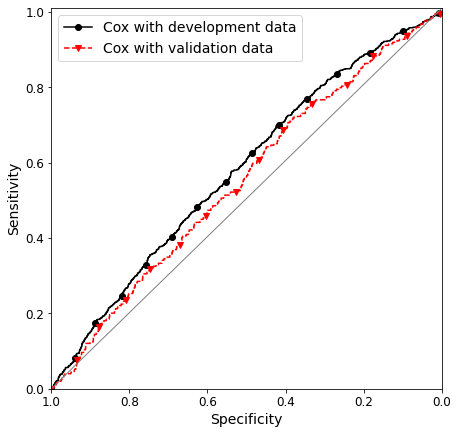

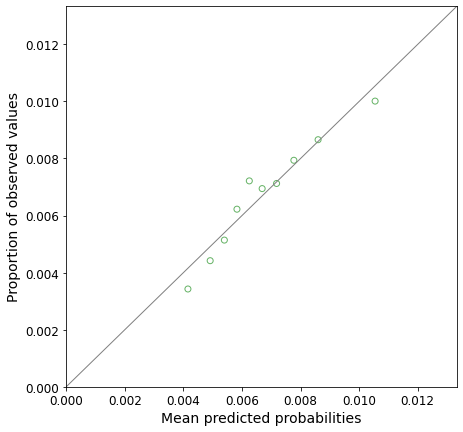

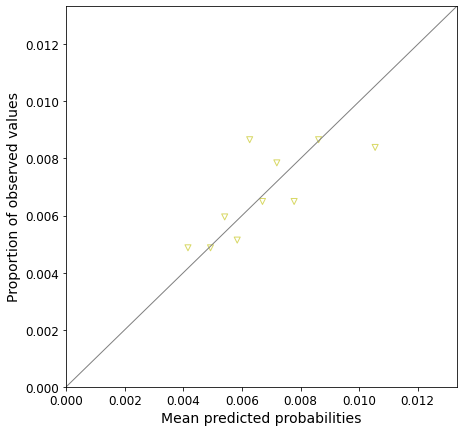

In [41]:
#data prep
data, data_lrti_no_abs_incdt_enc = cox_data_prep(data_lrti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)

try:
    #build cox model 
    cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test = cox_model_build('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_no_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_incdt.csv', data_lrti_no_abs_incdt_enc, data_lrti_no_abs_incdt, 'sum_betas_cph_lrti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_no_abs_incdt, 'event_lrti_admitted', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, 'event_lrti_admitted', data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_incdt_train.jpg', 'calibration_cph_lrti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_no_abs_incdt, 'lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 12277 total observations, 12201 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12277
number of events observed = 76
   partial log-likelihood = -704.86
         time fit was run = 2023-06-19 11:57:48 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.53       1.70       0.36            -0.17             1.23                 0.84                 3.42
CCI_cat[T.medium]        -0.09       0.91       0.43            -0.93             0.75                 0.39                 2.11
CCI_cat[T.high]           0.25       1.29       0.48            -0.68             1.18                 0.51                 3.27
CCI_cat[T.very_high]     -0.05       0.95       0.45            -0.93             0.82                 0.39                 2.28
age_cat[T.25_34]          0.17       1.19       0.49            -0.78             1.12                 0.46                 3.08
age_cat[T.35_44]          0.42       1.52       0.46            -0.48             1.31                 0.62                 3.71
age_cat[T.45_54]          0.48       1.62       0.45            -0.40             1.36                 0.67                 3.92
age_cat[T.55_64]          0.33       1.39       0.47            -0.58             1.24                 0.56                 3.45
age_cat[T.65_74]          0.47       1.60       0.45            -0.41             1.35                 0.66                 3.86
age_cat[T.75_more]        0.25       1.28       0.48            -0.68             1.18                 0.50                 3.25
antibacterial_brit       -0.10       0.91       0.08            -0.26             0.07                 0.77                 1.07
bmi_cat[T.obese]         -0.10       0.90       0.41            -0.91             0.71                 0.40                 2.03
bmi_cat[T.overweight]    -0.37       0.69       0.56            -1.47             0.72                 0.23                 2.05
bmi_cat[T.underweight]   -0.24       0.79       0.80            -1.81             1.34                 0.16                 3.81
bmi_cat[T.unknown]        0.13       1.14       0.43            -0.71             0.97                 0.49                 2.65
ethnicity[T.unknown]      0.08       1.08       0.36            -0.63             0.78                 0.53                 2.18
ethnicity[T.white]       -0.17       0.84       0.33            -0.82             0.47                 0.44                 1.60
flu_vaccine[T.yes]        0.26       1.29       0.36            -0.44             0.95                 0.64                 2.59
imd[T.medium]             0.26       1.29       0.39            -0.50             1.02                 0.60                 2.77
imd[T.unaffluent]         0.24       1.27       0.39            -0.52             1.00                 0.59                 2.72
imd[T.unknown]           -0.51       0.60       0.76            -2.01             0.99                 0.13                 2.69
imd[T.very_affluent]      0.07       1.07       0.41            -0.73             0.87                 0.48                 2.39
imd[T.very_unaffluent]    0.49       1.64       0.37            -0.22             1.21                 0.80                 3.36
region[T.east_midlands]  -0.44       0.65       0.53            -1.47             0.60                 0.23                 1.82
region[T.london]         -0.04       0.96       0.41            -0.85             0.77                 0.43                 2.15
region[T.north_east]     -0.60       0.55       0.56            -1.70             0.49                 0.18                

12749


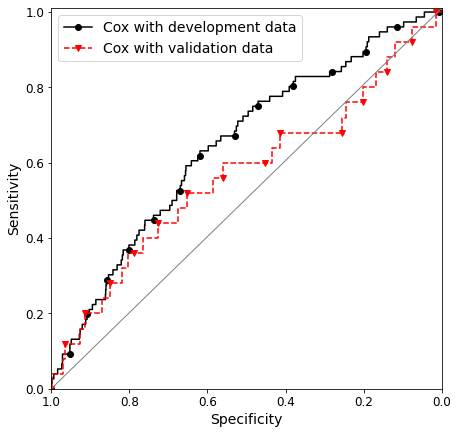

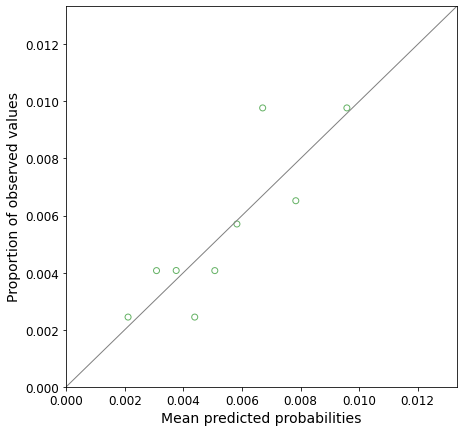

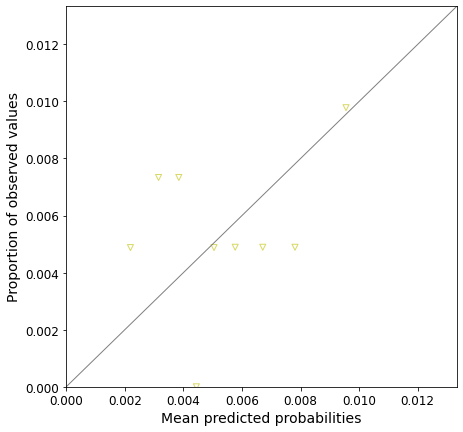

In [42]:
#data prep
data, data_lrti_abs_incdt_enc = cox_data_prep(data_lrti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_incdt', data_lrti_abs_incdt)

try:
    #build cox model 
    cph_lrti_abs_incdt, data_lrti_abs_incdt_train, data_lrti_abs_incdt_test = cox_model_build('lrti', 'abs_incdt', data_lrti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_incdt.csv', data_lrti_abs_incdt_enc, data_lrti_abs_incdt, 'sum_betas_cph_lrti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_abs_incdt, 'event_lrti_admitted', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_abs_incdt, data_lrti_abs_incdt_train, 'event_lrti_admitted', data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_incdt_train.jpg', 'calibration_cph_lrti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_abs_incdt, 'lrti', 'abs_incdt', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 12531 total observations, 12444 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12531
number of events observed = 87
   partial log-likelihood = -803.60
         time fit was run = 2023-06-19 11:57:58 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.17       0.84       0.30            -0.77             0.43                 0.46                 1.53
CCI_cat[T.medium]        -0.23       0.80       0.35            -0.91             0.46                 0.40                 1.58
CCI_cat[T.high]          -0.12       0.89       0.41            -0.93             0.69                 0.40                 2.00
CCI_cat[T.very_high]     -0.10       0.90       0.36            -0.80             0.59                 0.45                 1.81
age_cat[T.25_34]         -0.40       0.67       0.53            -1.44             0.63                 0.24                 1.88
age_cat[T.35_44]          0.26       1.29       0.45            -0.62             1.14                 0.54                 3.12
age_cat[T.45_54]          0.33       1.39       0.43            -0.52             1.18                 0.59                 3.25
age_cat[T.55_64]          0.76       2.14       0.40            -0.03             1.55                 0.97                 4.70
age_cat[T.65_74]          0.68       1.97       0.41            -0.11             1.47                 0.89                 4.37
age_cat[T.75_more]       -0.04       0.96       0.47            -0.97             0.88                 0.38                 2.42
antibacterial_brit        0.02       1.02       0.07            -0.13             0.16                 0.88                 1.18
bmi_cat[T.obese]          0.35       1.42       0.47            -0.57             1.28                 0.56                 3.58
bmi_cat[T.overweight]    -0.17       0.84       0.61            -1.36             1.02                 0.26                 2.77
bmi_cat[T.underweight]    0.71       2.03       0.67            -0.61             2.03                 0.54                 7.60
bmi_cat[T.unknown]        0.51       1.67       0.49            -0.44             1.47                 0.64                 4.36
ethnicity[T.unknown]     -0.09       0.91       0.36            -0.79             0.61                 0.45                 1.83
ethnicity[T.white]        0.02       1.02       0.31            -0.59             0.62                 0.55                 1.86
flu_vaccine[T.yes]        0.20       1.22       0.34            -0.46             0.86                 0.63                 2.36
imd[T.medium]            -0.35       0.70       0.36            -1.06             0.36                 0.35                 1.43
imd[T.unaffluent]         0.13       1.14       0.31            -0.48             0.75                 0.62                 2.12
imd[T.unknown]           -0.15       0.86       0.55            -1.23             0.93                 0.29                 2.53
imd[T.very_affluent]     -0.58       0.56       0.39            -1.35             0.18                 0.26                 1.20
imd[T.very_unaffluent]    0.05       1.05       0.32            -0.59             0.68                 0.55                 1.98
region[T.east_midlands]  -0.08       0.92       0.52            -1.10             0.93                 0.33                 2.54
region[T.london]         -0.21       0.81       0.46            -1.11             0.68                 0.33                 1.98
region[T.north_east]      0.14       1.15       0.49            -0.82             1.09                 0.44                

12746


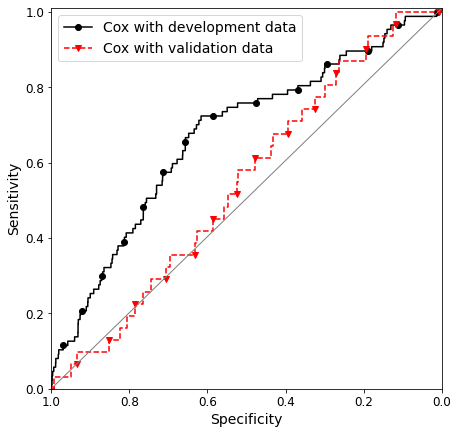

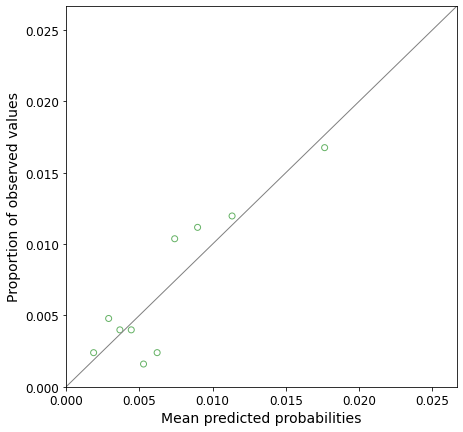

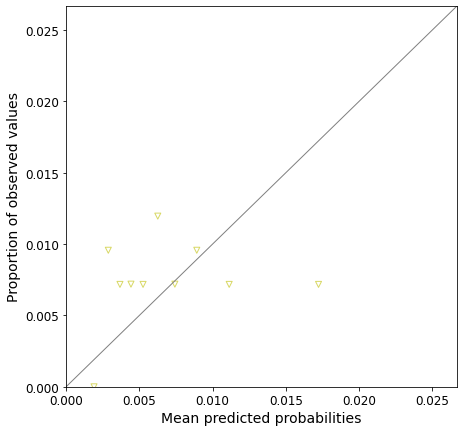

In [43]:
#data prep
data, data_lrti_no_abs_prevl_enc = cox_data_prep(data_lrti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)

try:
    #build cox model 
    cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test = cox_model_build('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_no_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_prevl.csv', data_lrti_no_abs_prevl_enc, data_lrti_no_abs_prevl, 'sum_betas_cph_lrti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_no_abs_prevl, 'event_lrti_admitted', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, 'event_lrti_admitted', data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_prevl_train.jpg', 'calibration_cph_lrti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_no_abs_prevl, 'lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 1343 total observations, 1335 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1343
number of events observed = 8
   partial log-likelihood = -26.69
         time fit was run = 2023-06-19 11:58:05 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           17.05   2.54e+07    9433.42        -18472.11         18506.22                 0.00                  inf
CCI_cat[T.medium]        -1.28       0.28   11906.55        -23337.68         23335.12                 0.00                  inf
CCI_cat[T.high]          19.43   2.75e+08    9433.42        -18469.73         18508.59                 0.00                  inf
CCI_cat[T.very_high]     21.04   1.37e+09    9433.42        -18468.13         18510.20                 0.00                  inf
age_cat[T.25_34]         -3.19       0.04       2.11            -7.33             0.94                 0.00                 2.55
age_cat[T.35_44]          0.10       1.11       1.41            -2.66             2.87                 0.07                17.65
age_cat[T.45_54]         -0.66       0.52       1.41            -3.43             2.11                 0.03                 8.25
age_cat[T.55_64]        -21.22       0.00    8880.58        -17426.85         17384.40                 0.00                  inf
age_cat[T.65_74]        -20.84       0.00    9734.83        -19100.76         19059.07                 0.00                  inf
age_cat[T.75_more]      -21.82       0.00   11222.75        -22018.00         21974.37                 0.00                  inf
antibacterial_brit       -0.74       0.48       0.55            -1.82             0.35                 0.16                 1.42
bmi_cat[T.obese]         20.89   1.18e+09    9687.92        -18967.09         19008.87                 0.00                  inf
bmi_cat[T.overweight]    -1.17       0.31   13722.57        -26896.91         26894.58                 0.00                  inf
bmi_cat[T.underweight]    2.44      11.49   24430.82        -47881.08         47885.96                 0.00                  inf
bmi_cat[T.unknown]       18.34   9.27e+07    9687.92        -18969.64         19006.33                 0.00                  inf
ethnicity[T.unknown]    -20.28       0.00    5403.59        -10611.12         10570.56                 0.00                  inf
ethnicity[T.white]        0.72       2.06       1.80            -2.81             4.26                 0.06                70.49
flu_vaccine[T.yes]        0.46       1.58       1.61            -2.70             3.62                 0.07                37.35
imd[T.medium]             3.44      31.15       1.88            -0.24             7.12                 0.78              1239.30
imd[T.unaffluent]         2.17       8.72       1.80            -1.36             5.69                 0.26               295.60
imd[T.unknown]          -17.02       0.00   11432.82        -22424.93         22390.90                 0.00                  inf
imd[T.very_affluent]      2.01       7.50       2.01            -1.92             5.95                 0.15               385.43
imd[T.very_unaffluent]  -18.28       0.00    7187.06        -14104.65         14068.09                 0.00                  inf
region[T.east_midlands]  17.93   6.15e+07   15548.17        -30455.91         30491.78                 0.00                  inf
region[T.london]         17.89   5.86e+07   15548.17        -30455.96         30491.73                 0.00                  inf
region[T.north_east]     -3.73       0.02   19265.89        -37764.18         37756.71                 0.00                  inf

13060


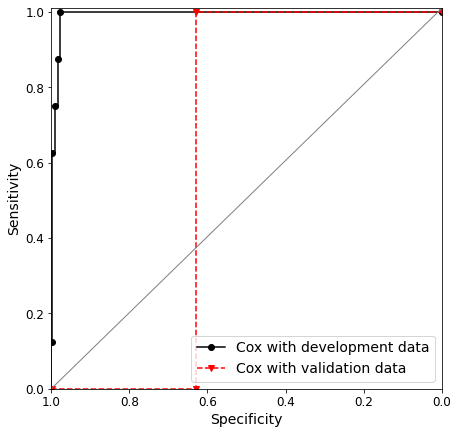

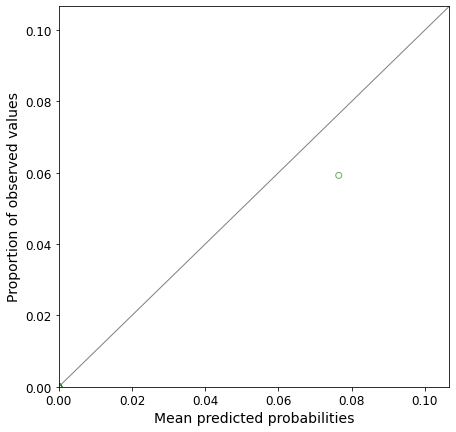

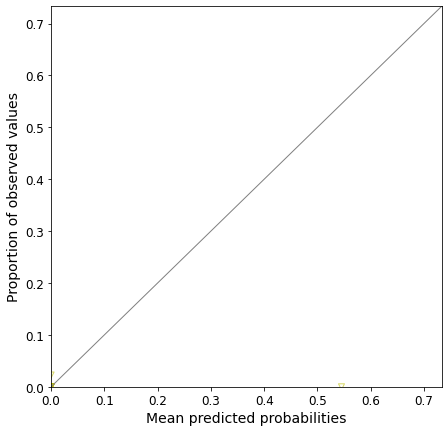

In [44]:
#data prep
data, data_lrti_abs_prevl_enc = cox_data_prep(data_lrti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_prevl', data_lrti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_prevl', data_lrti_abs_prevl)

try:
    #build cox model 
    cph_lrti_abs_prevl, data_lrti_abs_prevl_train, data_lrti_abs_prevl_test = cox_model_build('lrti', 'abs_prevl', data_lrti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_prevl.csv', data_lrti_abs_prevl_enc, data_lrti_abs_prevl, 'sum_betas_cph_lrti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_abs_prevl, 'event_lrti_admitted', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_abs_prevl, data_lrti_abs_prevl_train, 'event_lrti_admitted', data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_prevl_train.jpg', 'calibration_cph_lrti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_abs_prevl, 'lrti', 'abs_prevl', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident lrti

In [45]:
#data prep
data, data_lrti_incdt_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'incdt', data_lrti_incdt_enc)
make_summary_table_hosped('lrti', 'incdt', data_lrti_incdt)

try:
    cph_lrti_incdt, data_lrti_incdt_train, data_lrti_incdt_test = cox_model_abs_build('lrti', 'incdt', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt, 'lrti', 'incdt', data_lrti_incdt_train, data_lrti_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 123155 total observations, 122351 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 123155
number of events observed = 804
   partial log-likelihood = -9394.45
         time fit was run = 2023-06-19 11:58:13 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.06       1.06       0.10            -0.15             0.26                 0.86                 1.30
CCI_cat[T.medium]        -0.03       0.97       0.12            -0.25             0.20                 0.78                 1.22
CCI_cat[T.high]          -0.16       0.86       0.15            -0.44             0.13                 0.64                 1.14
CCI_cat[T.very_high]      0.01       1.01       0.12            -0.23             0.24                 0.79                 1.28
age_cat[T.25_34]          0.21       1.23       0.13            -0.04             0.46                 0.96                 1.59
age_cat[T.35_44]         -0.01       0.99       0.13            -0.27             0.25                 0.76                 1.29
age_cat[T.45_54]          0.09       1.10       0.13            -0.17             0.35                 0.85                 1.42
age_cat[T.55_64]         -0.04       0.96       0.14            -0.31             0.22                 0.73                 1.25
age_cat[T.65_74]          0.01       1.01       0.13            -0.26             0.27                 0.77                 1.31
age_cat[T.75_more]       -0.05       0.95       0.14            -0.32             0.22                 0.73                 1.24
antibacterial_brit        0.03       1.03       0.02            -0.02             0.08                 0.98                 1.08
bmi_cat[T.obese]         -0.11       0.90       0.13            -0.36             0.15                 0.70                 1.16
bmi_cat[T.overweight]     0.08       1.08       0.15            -0.23             0.38                 0.80                 1.46
bmi_cat[T.underweight]   -0.01       0.99       0.23            -0.45             0.44                 0.64                 1.55
bmi_cat[T.unknown]       -0.12       0.88       0.14            -0.39             0.15                 0.67                 1.16
ethnicity[T.unknown]      0.06       1.06       0.11            -0.17             0.28                 0.85                 1.32
ethnicity[T.white]       -0.02       0.98       0.10            -0.22             0.18                 0.80                 1.20
flu_vaccine[T.yes]       -0.08       0.92       0.12            -0.32             0.15                 0.72                 1.17
imd[T.medium]             0.30       1.35       0.12             0.07             0.53                 1.07                 1.70
imd[T.unaffluent]         0.16       1.17       0.12            -0.08             0.39                 0.92                 1.48
imd[T.unknown]            0.41       1.51       0.17             0.08             0.74                 1.09                 2.09
imd[T.very_affluent]      0.13       1.14       0.12            -0.11             0.37                 0.90                 1.45
imd[T.very_unaffluent]    0.28       1.32       0.12             0.05             0.51                 1.05                 1.66
lrti_ab_date             -0.07       0.93       0.12            -0.31             0.16                 0.73                 1.18
region[T.east_midlands]  -0.33       0.72       0.15            -0.63            -0.03                 0.53                 0.97
region[T.london]         -0.35       0.70       0.13            -0.61            -0.10                 0.55           

13027


### 5-6- hospital admission related to prevalent lrti

In [46]:
#data prep
data, data_lrti_prevl_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'prevl', data_lrti_prevl_enc)
make_summary_table_hosped('lrti', 'prevl', data_lrti_prevl)

try:
    cph_lrti_prevl, data_lrti_prevl_train, data_lrti_prevl_test = cox_model_abs_build('lrti', 'prevl', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl, 'lrti', 'prevl', data_lrti_prevl_train, data_lrti_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13875 total observations, 13774 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13875
number of events observed = 101
   partial log-likelihood = -942.60
         time fit was run = 2023-06-19 11:58:26 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.17       1.19       0.31            -0.43             0.77                 0.65                 2.16
CCI_cat[T.medium]         0.03       1.03       0.35            -0.65             0.71                 0.52                 2.03
CCI_cat[T.high]           0.29       1.33       0.39            -0.48             1.05                 0.62                 2.85
CCI_cat[T.very_high]      0.19       1.21       0.35            -0.49             0.88                 0.61                 2.41
age_cat[T.25_34]         -0.39       0.68       0.43            -1.23             0.45                 0.29                 1.57
age_cat[T.35_44]         -0.01       0.99       0.39            -0.76             0.75                 0.47                 2.11
age_cat[T.45_54]          0.10       1.10       0.37            -0.63             0.83                 0.53                 2.29
age_cat[T.55_64]          0.11       1.12       0.37            -0.61             0.83                 0.54                 2.29
age_cat[T.65_74]          0.42       1.52       0.34            -0.25             1.09                 0.78                 2.97
age_cat[T.75_more]       -0.18       0.84       0.39            -0.95             0.59                 0.39                 1.81
antibacterial_brit        0.04       1.04       0.07            -0.10             0.17                 0.91                 1.19
bmi_cat[T.obese]          0.09       1.09       0.38            -0.66             0.83                 0.52                 2.30
bmi_cat[T.overweight]    -0.78       0.46       0.57            -1.89             0.34                 0.15                 1.41
bmi_cat[T.underweight]    0.65       1.91       0.54            -0.41             1.71                 0.66                 5.52
bmi_cat[T.unknown]        0.19       1.20       0.40            -0.60             0.97                 0.55                 2.65
ethnicity[T.unknown]      0.23       1.26       0.38            -0.52             0.99                 0.59                 2.69
ethnicity[T.white]        0.55       1.73       0.34            -0.11             1.21                 0.89                 3.36
flu_vaccine[T.yes]        0.40       1.49       0.29            -0.17             0.97                 0.85                 2.63
imd[T.medium]            -0.08       0.92       0.33            -0.73             0.58                 0.48                 1.78
imd[T.unaffluent]         0.30       1.35       0.30            -0.29             0.89                 0.75                 2.43
imd[T.unknown]           -0.47       0.62       0.62            -1.69             0.75                 0.18                 2.11
imd[T.very_affluent]     -0.45       0.64       0.37            -1.18             0.27                 0.31                 1.31
imd[T.very_unaffluent]    0.19       1.21       0.31            -0.42             0.80                 0.66                 2.22
lrti_ab_date             -0.35       0.70       0.39            -1.12             0.42                 0.33                 1.52
region[T.east_midlands]  -0.43       0.65       0.46            -1.33             0.46                 0.27                 1.59
region[T.london]         -0.46       0.63       0.39            -1.22             0.30                 0.29               

13015


### 5-7- hospital admission related to incident lrti with prescribed antibiotics categories

In [47]:
#data prep
data, data_lrti_incdt_abs_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_abs, data_lrti_incdt_abs_train, data_lrti_incdt_abs_test = cox_model_ab_type_build('lrti', 'incdt_ab_type', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_abs, 'lrti', 'incdt_abs', data_lrti_incdt_abs_train, data_lrti_incdt_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 123155 total observations, 122351 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 123155
number of events observed = 804
   partial log-likelihood = -9392.89
         time fit was run = 2023-06-19 11:58:33 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
CCI_cat[T.low]               0.06       1.06       0.10            -0.15             0.26                 0.86                 1.30
CCI_cat[T.medium]           -0.03       0.97       0.12            -0.25             0.20                 0.78                 1.22
CCI_cat[T.high]             -0.16       0.86       0.15            -0.44             0.13                 0.64                 1.14
CCI_cat[T.very_high]         0.01       1.01       0.12            -0.23             0.24                 0.79                 1.28
ab_type_cat[T.Doxycycline]   0.17       1.18       0.68            -1.16             1.49                 0.31                 4.45
ab_type_cat[T.no]           -0.43       0.65       0.36            -1.12             0.27                 0.32                 1.31
ab_type_cat[T.other]        -0.57       0.56       0.38            -1.31             0.16                 0.27                 1.18
age_cat[T.25_34]             0.21       1.23       0.13            -0.04             0.46                 0.96                 1.59
age_cat[T.35_44]            -0.01       0.99       0.13            -0.27             0.26                 0.76                 1.29
age_cat[T.45_54]             0.09       1.10       0.13            -0.16             0.35                 0.85                 1.42
age_cat[T.55_64]            -0.04       0.96       0.14            -0.31             0.22                 0.73                 1.25
age_cat[T.65_74]             0.01       1.01       0.13            -0.26             0.27                 0.77                 1.31
age_cat[T.75_more]          -0.05       0.95       0.14            -0.31             0.22                 0.73                 1.24
antibacterial_brit           0.03       1.03       0.02            -0.02             0.08                 0.98                 1.08
bmi_cat[T.obese]            -0.10       0.90       0.13            -0.36             0.15                 0.70                 1.16
bmi_cat[T.overweight]        0.08       1.08       0.15            -0.23             0.38                 0.80                 1.46
bmi_cat[T.underweight]      -0.01       0.99       0.23            -0.45             0.44                 0.64                 1.55
bmi_cat[T.unknown]          -0.12       0.88       0.14            -0.39             0.15                 0.67                 1.16
ethnicity[T.unknown]         0.06       1.06       0.11            -0.17             0.28                 0.85                 1.32
ethnicity[T.white]          -0.02       0.98       0.10            -0.22             0.18                 0.80                 1.20
flu_vaccine[T.yes]          -0.08       0.92       0.12            -0.32             0.16                 0.72                 1.17
imd[T.medium]                0.30       1.35       0.12             0.07             0.53                 1.07                 1.69
imd[T.unaffluent]            0.16       1.17       0.12            -0.08             0.39                 0.92                 1.48
imd[T.unknown]               0.41       1.51       0.17             0.08             0.74                 1.09                 2.09
imd[T.very_affluent]         0.13       1.14       0.12            -0.10             0.37                 0.90                 1.45
imd[T.very_unaffluent]       0.28    

13592


### 5-8- hospital admission related to prevalent lrti with prescribed antibiotics categories

In [48]:
#data prep
data, data_lrti_prevl_abs_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_abs, data_lrti_prevl_abs_train, data_lrti_prevl_abs_test = cox_model_ab_type_build('lrti', 'prevl_ab_type', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_abs, 'lrti', 'prevl_abs', data_lrti_prevl_abs_train, data_lrti_prevl_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13875 total observations, 13774 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13875
number of events observed = 101
   partial log-likelihood = -942.20
         time fit was run = 2023-06-19 11:58:45 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
CCI_cat[T.low]               0.17       1.18       0.31            -0.43             0.77                 0.65                 2.16
CCI_cat[T.medium]            0.03       1.03       0.35            -0.65             0.70                 0.52                 2.02
CCI_cat[T.high]              0.28       1.33       0.39            -0.48             1.04                 0.62                 2.84
CCI_cat[T.very_high]         0.19       1.21       0.35            -0.49             0.88                 0.61                 2.41
ab_type_cat[T.Doxycycline] -13.25       0.00    1361.21         -2681.18          2654.67                 0.00                  inf
ab_type_cat[T.no]           -0.45       0.64       1.01            -2.43             1.53                 0.09                 4.62
ab_type_cat[T.other]        -0.86       0.42       1.08            -2.99             1.26                 0.05                 3.52
age_cat[T.25_34]            -0.39       0.68       0.43            -1.22             0.45                 0.29                 1.57
age_cat[T.35_44]            -0.01       0.99       0.39            -0.76             0.75                 0.47                 2.11
age_cat[T.45_54]             0.10       1.10       0.37            -0.63             0.83                 0.53                 2.29
age_cat[T.55_64]             0.11       1.12       0.37            -0.61             0.83                 0.55                 2.29
age_cat[T.65_74]             0.42       1.52       0.34            -0.25             1.09                 0.78                 2.97
age_cat[T.75_more]          -0.18       0.84       0.39            -0.95             0.60                 0.39                 1.81
antibacterial_brit           0.04       1.04       0.07            -0.10             0.17                 0.91                 1.19
bmi_cat[T.obese]             0.09       1.09       0.38            -0.66             0.83                 0.52                 2.29
bmi_cat[T.overweight]       -0.77       0.46       0.57            -1.89             0.35                 0.15                 1.41
bmi_cat[T.underweight]       0.65       1.91       0.54            -0.41             1.71                 0.66                 5.53
bmi_cat[T.unknown]           0.18       1.20       0.40            -0.60             0.97                 0.55                 2.64
ethnicity[T.unknown]         0.23       1.26       0.38            -0.52             0.99                 0.59                 2.68
ethnicity[T.white]           0.55       1.73       0.34            -0.11             1.21                 0.89                 3.36
flu_vaccine[T.yes]           0.40       1.49       0.29            -0.17             0.97                 0.85                 2.63
imd[T.medium]               -0.07       0.93       0.33            -0.73             0.58                 0.48                 1.79
imd[T.unaffluent]            0.30       1.36       0.30            -0.28             0.89                 0.75                 2.44
imd[T.unknown]              -0.47       0.63       0.62            -1.69             0.75                 0.18                 2.12
imd[T.very_affluent]        -0.45       0.64       0.37            -1.17             0.27                 0.31                 1.31
imd[T.very_unaffluent]       0.19       1

13591


### 5-9- stratified by sex
#### 5-9-1- incident males

In [49]:
#data prep
data, data_lrti_incdt_males_enc = cox_data_prep(data_lrti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_males, data_lrti_incdt_males_train, data_lrti_incdt_males_test = cox_model_strat_sex_build('lrti', 'incdt_males', data_lrti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_males, 'lrti', 'incdt_males', data_lrti_incdt_males_train, data_lrti_incdt_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 60243 total observations, 59841 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 60243
number of events observed = 402
   partial log-likelihood = -4395.85
         time fit was run = 2023-06-19 11:58:47 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.12       1.13       0.15            -0.17             0.42                 0.84                 1.52
CCI_cat[T.medium]         0.08       1.08       0.17            -0.25             0.41                 0.78                 1.50
CCI_cat[T.high]          -0.08       0.92       0.21            -0.49             0.33                 0.61                 1.39
CCI_cat[T.very_high]      0.21       1.23       0.17            -0.13             0.54                 0.88                 1.72
age_cat[T.25_34]          0.48       1.62       0.19             0.12             0.85                 1.13                 2.34
age_cat[T.35_44]          0.14       1.15       0.20            -0.25             0.53                 0.78                 1.69
age_cat[T.45_54]          0.38       1.46       0.19             0.01             0.75                 1.01                 2.12
age_cat[T.55_64]          0.07       1.07       0.20            -0.32             0.47                 0.72                 1.60
age_cat[T.65_74]          0.22       1.24       0.20            -0.17             0.60                 0.84                 1.83
age_cat[T.75_more]        0.07       1.07       0.20            -0.33             0.47                 0.72                 1.60
antibacterial_brit        0.05       1.05       0.03            -0.02             0.12                 0.98                 1.12
bmi_cat[T.obese]          0.27       1.31       0.21            -0.15             0.68                 0.86                 1.98
bmi_cat[T.overweight]     0.39       1.47       0.25            -0.09             0.87                 0.91                 2.38
bmi_cat[T.underweight]    0.22       1.25       0.35            -0.46             0.91                 0.63                 2.49
bmi_cat[T.unknown]        0.25       1.29       0.22            -0.19             0.69                 0.83                 1.99
ethnicity[T.unknown]      0.14       1.15       0.17            -0.19             0.48                 0.83                 1.61
ethnicity[T.white]        0.18       1.20       0.15            -0.12             0.48                 0.89                 1.61
flu_vaccine[T.yes]       -0.32       0.73       0.19            -0.69             0.05                 0.50                 1.05
imd[T.medium]             0.16       1.18       0.16            -0.15             0.47                 0.86                 1.60
imd[T.unaffluent]        -0.01       0.99       0.16            -0.34             0.31                 0.72                 1.36
imd[T.unknown]            0.54       1.71       0.21             0.12             0.95                 1.13                 2.58
imd[T.very_affluent]     -0.23       0.79       0.17            -0.57             0.11                 0.56                 1.12
imd[T.very_unaffluent]    0.02       1.02       0.16            -0.30             0.34                 0.74                 1.41
lrti_ab_date             -0.35       0.71       0.19            -0.72             0.03                 0.48                 1.03
region[T.east_midlands]  -0.01       0.99       0.21            -0.42             0.40                 0.66                 1.49
region[T.london]         -0.21       0.81       0.19            -0.57             0.16                 0.56              

12746


#### 5-9-2- incident females

In [50]:
#data prep
data, data_lrti_incdt_females_enc = cox_data_prep(data_lrti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_females, data_lrti_incdt_females_train, data_lrti_incdt_females_test = cox_model_strat_sex_build('lrti', 'incdt_females', data_lrti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_females, 'lrti', 'incdt_females', data_lrti_incdt_females_train, data_lrti_incdt_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 62911 total observations, 62493 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 62911
number of events observed = 418
   partial log-likelihood = -4593.97
         time fit was run = 2023-06-19 11:58:58 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.05       1.05       0.15            -0.25             0.35                 0.78                 1.41
CCI_cat[T.medium]         0.04       1.04       0.17            -0.29             0.36                 0.75                 1.44
CCI_cat[T.high]           0.17       1.19       0.19            -0.20             0.55                 0.82                 1.73
CCI_cat[T.very_high]      0.27       1.31       0.17            -0.05             0.60                 0.95                 1.82
age_cat[T.25_34]          0.21       1.23       0.19            -0.17             0.58                 0.85                 1.79
age_cat[T.35_44]          0.22       1.24       0.19            -0.15             0.59                 0.86                 1.80
age_cat[T.45_54]          0.30       1.36       0.19            -0.06             0.67                 0.94                 1.96
age_cat[T.55_64]          0.15       1.16       0.19            -0.23             0.53                 0.80                 1.69
age_cat[T.65_74]          0.09       1.10       0.20            -0.29             0.47                 0.75                 1.61
age_cat[T.75_more]        0.23       1.26       0.19            -0.14             0.60                 0.87                 1.82
antibacterial_brit        0.03       1.03       0.03            -0.03             0.10                 0.97                 1.10
bmi_cat[T.obese]         -0.13       0.88       0.19            -0.49             0.23                 0.61                 1.26
bmi_cat[T.overweight]     0.17       1.18       0.22            -0.26             0.60                 0.77                 1.81
bmi_cat[T.underweight]    0.23       1.26       0.30            -0.35             0.82                 0.71                 2.27
bmi_cat[T.unknown]        0.02       1.02       0.20            -0.37             0.40                 0.69                 1.49
ethnicity[T.unknown]      0.03       1.03       0.16            -0.29             0.34                 0.75                 1.41
ethnicity[T.white]        0.05       1.05       0.14            -0.23             0.33                 0.80                 1.40
flu_vaccine[T.yes]        0.18       1.19       0.15            -0.13             0.48                 0.88                 1.61
imd[T.medium]             0.49       1.63       0.18             0.15             0.83                 1.16                 2.30
imd[T.unaffluent]         0.46       1.59       0.18             0.12             0.81                 1.13                 2.24
imd[T.unknown]            0.42       1.51       0.25            -0.08             0.91                 0.92                 2.49
imd[T.very_affluent]      0.43       1.53       0.18             0.08             0.77                 1.08                 2.17
imd[T.very_unaffluent]    0.57       1.77       0.17             0.23             0.91                 1.26                 2.48
lrti_ab_date              0.07       1.07       0.16            -0.24             0.38                 0.79                 1.46
region[T.east_midlands]  -0.43       0.65       0.22            -0.85            -0.01                 0.43                 0.99
region[T.london]         -0.45       0.64       0.18            -0.80            -0.10                 0.45              

12741


#### 5-9-3- prevalent males

In [51]:
#data prep
data, data_lrti_prevl_males_enc = cox_data_prep(data_lrti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_males, data_lrti_prevl_males_train, data_lrti_prevl_males_test = cox_model_strat_sex_build('lrti', 'prevl_males', data_lrti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_lrti_prevl_males, 'lrti', 'prevl_males', data_lrti_prevl_males_train, data_lrti_prevl_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6906 total observations, 6858 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6906
number of events observed = 48
   partial log-likelihood = -409.95
         time fit was run = 2023-06-19 11:59:05 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.00       1.00       0.43            -0.85             0.85                 0.43                 2.35
CCI_cat[T.medium]        -0.11       0.90       0.50            -1.10             0.88                 0.33                 2.40
CCI_cat[T.high]           0.46       1.58       0.52            -0.56             1.48                 0.57                 4.38
CCI_cat[T.very_high]      0.27       1.31       0.49            -0.69             1.23                 0.50                 3.41
age_cat[T.25_34]         -0.11       0.90       0.63            -1.35             1.14                 0.26                 3.11
age_cat[T.35_44]          0.17       1.19       0.61            -1.02             1.36                 0.36                 3.92
age_cat[T.45_54]          0.54       1.72       0.56            -0.55             1.64                 0.58                 5.15
age_cat[T.55_64]          0.41       1.51       0.57            -0.71             1.54                 0.49                 4.65
age_cat[T.65_74]          0.68       1.97       0.54            -0.38             1.74                 0.68                 5.71
age_cat[T.75_more]       -0.35       0.71       0.67            -1.67             0.97                 0.19                 2.64
antibacterial_brit       -0.01       0.99       0.10            -0.21             0.19                 0.81                 1.21
bmi_cat[T.obese]          0.65       1.92       0.74            -0.79             2.10                 0.45                 8.13
bmi_cat[T.overweight]     0.29       1.34       0.87            -1.41             2.00                 0.24                 7.35
bmi_cat[T.underweight]    0.78       2.19       1.00            -1.18             2.75                 0.31                15.63
bmi_cat[T.unknown]        0.78       2.19       0.76            -0.70             2.27                 0.49                 9.67
ethnicity[T.unknown]      0.02       1.02       0.48            -0.92             0.96                 0.40                 2.60
ethnicity[T.white]        0.02       1.02       0.42            -0.81             0.85                 0.45                 2.34
flu_vaccine[T.yes]       -0.51       0.60       0.60            -1.69             0.66                 0.19                 1.93
imd[T.medium]            -0.75       0.47       0.55            -1.82             0.33                 0.16                 1.39
imd[T.unaffluent]        -0.01       0.99       0.44            -0.88             0.85                 0.42                 2.33
imd[T.unknown]           -0.83       0.43       1.05            -2.89             1.23                 0.06                 3.41
imd[T.very_affluent]     -0.37       0.69       0.49            -1.34             0.60                 0.26                 1.82
imd[T.very_unaffluent]    0.28       1.33       0.42            -0.53             1.10                 0.59                 3.00
lrti_ab_date             -1.54       0.21       1.01            -3.52             0.44                 0.03                 1.56
region[T.east_midlands]   0.36       1.43       0.61            -0.84             1.55                 0.43                 4.70
region[T.london]         -0.41       0.66       0.61            -1.60             0.78                 0.20                 2.

12743


#### 5-9-4- prevalent females

In [52]:
try:
    #data prep
    data, data_lrti_prevl_females_enc = cox_data_prep(data_lrti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

    #cox model
    cph_lrti_prevl_females, data_lrti_prevl_females_train, data_lrti_prevl_females_test = cox_model_strat_sex_build('lrti', 'prevl_females', data_lrti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_females, 'lrti', 'prevl_females', data_lrti_prevl_females_train, data_lrti_prevl_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6968 total observations, 6917 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6968
number of events observed = 51
   partial log-likelihood = -432.67
         time fit was run = 2023-06-19 11:59:07 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.29       0.75       0.39            -1.05             0.47                 0.35                 1.61
CCI_cat[T.medium]        -0.24       0.78       0.43            -1.08             0.59                 0.34                 1.81
CCI_cat[T.high]          -0.04       0.96       0.51            -1.04             0.96                 0.36                 2.61
CCI_cat[T.very_high]     -0.65       0.52       0.51            -1.65             0.35                 0.19                 1.42
age_cat[T.25_34]         -0.62       0.54       0.61            -1.82             0.58                 0.16                 1.79
age_cat[T.35_44]          0.08       1.09       0.50            -0.90             1.07                 0.41                 2.91
age_cat[T.45_54]          0.15       1.16       0.49            -0.81             1.11                 0.44                 3.02
age_cat[T.55_64]          0.36       1.44       0.47            -0.55             1.28                 0.58                 3.59
age_cat[T.65_74]         -0.05       0.95       0.52            -1.07             0.96                 0.34                 2.62
age_cat[T.75_more]       -0.64       0.53       0.61            -1.84             0.57                 0.16                 1.76
antibacterial_brit        0.09       1.09       0.10            -0.10             0.28                 0.90                 1.32
bmi_cat[T.obese]          0.87       2.38       0.73            -0.57             2.30                 0.57                10.00
bmi_cat[T.overweight]     0.08       1.08       0.91            -1.72             1.87                 0.18                 6.49
bmi_cat[T.underweight]    1.73       5.65       0.87             0.03             3.44                 1.03                31.06
bmi_cat[T.unknown]        0.80       2.23       0.76            -0.69             2.29                 0.50                 9.91
ethnicity[T.unknown]     -0.39       0.68       0.46            -1.29             0.51                 0.27                 1.67
ethnicity[T.white]       -0.18       0.83       0.38            -0.92             0.56                 0.40                 1.75
flu_vaccine[T.yes]       -0.03       0.97       0.47            -0.96             0.90                 0.38                 2.45
imd[T.medium]             0.09       1.09       0.38            -0.65             0.83                 0.52                 2.30
imd[T.unaffluent]        -0.39       0.68       0.42            -1.20             0.43                 0.30                 1.54
imd[T.unknown]           -0.30       0.74       0.64            -1.55             0.96                 0.21                 2.60
imd[T.very_affluent]     -1.00       0.37       0.52            -2.02             0.02                 0.13                 1.02
imd[T.very_unaffluent]   -1.00       0.37       0.52            -2.02             0.02                 0.13                 1.02
lrti_ab_date              0.22       1.25       0.44            -0.63             1.08                 0.53                 2.95
region[T.east_midlands]  -1.66       0.19       1.10            -3.81             0.49                 0.02                 1.63
region[T.london]          0.01       1.01       0.55            -1.07             1.09                 0.34                 2.

12751


### 5-10- stratified by age category
#### 5-10-1- incident

In [53]:
#data prep
data, data_lrti_incdt_15_24_enc = cox_data_prep(data_lrti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_15_24, data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test = cox_model_strat_age_build('lrti', 'incdt_15_24', data_lrti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_15_24, 'lrti', 'incdt_15_24', data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17584 total observations, 17475 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17584
number of events observed = 109
   partial log-likelihood = -1050.64
         time fit was run = 2023-06-19 11:59:09 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.17       1.19       0.29            -0.39             0.74                 0.68                 2.09
CCI_cat[T.medium]         0.12       1.12       0.32            -0.52             0.75                 0.60                 2.12
CCI_cat[T.high]          -0.32       0.73       0.43            -1.16             0.52                 0.31                 1.69
CCI_cat[T.very_high]      0.21       1.23       0.33            -0.44             0.85                 0.64                 2.35
antibacterial_brit        0.04       1.04       0.07            -0.10             0.17                 0.91                 1.18
bmi_cat[T.obese]         -0.45       0.63       0.31            -1.06             0.15                 0.35                 1.16
bmi_cat[T.overweight]    -0.26       0.77       0.38            -1.00             0.49                 0.37                 1.62
bmi_cat[T.underweight]   -0.62       0.54       0.64            -1.88             0.64                 0.15                 1.89
bmi_cat[T.unknown]       -0.68       0.51       0.35            -1.37             0.01                 0.25                 1.01
ethnicity[T.unknown]     -0.36       0.70       0.32            -0.99             0.27                 0.37                 1.31
ethnicity[T.white]       -0.08       0.93       0.26            -0.59             0.44                 0.55                 1.56
flu_vaccine[T.yes]        0.01       1.01       0.32            -0.62             0.63                 0.54                 1.89
imd[T.medium]             0.66       1.93       0.31             0.04             1.27                 1.04                 3.57
imd[T.unaffluent]         0.53       1.69       0.32            -0.10             1.15                 0.91                 3.15
imd[T.unknown]            0.25       1.28       0.51            -0.76             1.26                 0.47                 3.51
imd[T.very_affluent]     -0.00       1.00       0.37            -0.72             0.71                 0.49                 2.04
imd[T.very_unaffluent]    0.28       1.33       0.34            -0.38             0.94                 0.69                 2.56
lrti_ab_date             -0.36       0.70       0.37            -1.08             0.36                 0.34                 1.43
region[T.east_midlands]  -0.41       0.66       0.43            -1.25             0.43                 0.29                 1.53
region[T.london]         -0.10       0.91       0.34            -0.76             0.57                 0.47                 1.76
region[T.north_east]     -0.75       0.47       0.49            -1.71             0.20                 0.18                 1.23
region[T.north_west]     -0.29       0.75       0.41            -1.10             0.52                 0.33                 1.69
region[T.south_east]      0.06       1.07       0.38            -0.68             0.81                 0.51                 2.24
region[T.south_west]     -0.12       0.89       0.40            -0.91             0.67                 0.40                 1.95
region[T.west_midlands]  -0.16       0.85       0.40            -0.95             0.63                 0.38                 1.87
region[T.yorkshire]      -0.12       0.89       0.40            -0.91             0.67                 0.40              

11380


In [54]:
#data prep
data, data_lrti_incdt_25_34_enc = cox_data_prep(data_lrti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_25_34, data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test = cox_model_strat_age_build('lrti', 'incdt_25_34', data_lrti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_25_34, 'lrti', 'incdt_25_34', data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17445 total observations, 17311 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17445
number of events observed = 134
   partial log-likelihood = -1294.80
         time fit was run = 2023-06-19 11:59:11 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.01       1.01       0.27            -0.51             0.53                 0.60                 1.70
CCI_cat[T.medium]         0.12       1.12       0.29            -0.44             0.68                 0.64                 1.97
CCI_cat[T.high]           0.31       1.36       0.32            -0.31             0.93                 0.73                 2.54
CCI_cat[T.very_high]     -0.04       0.96       0.31            -0.65             0.57                 0.52                 1.77
antibacterial_brit       -0.00       1.00       0.06            -0.12             0.11                 0.88                 1.12
bmi_cat[T.obese]          0.09       1.09       0.36            -0.61             0.79                 0.54                 2.19
bmi_cat[T.overweight]     0.20       1.22       0.42            -0.62             1.02                 0.54                 2.77
bmi_cat[T.underweight]   -0.63       0.53       0.78            -2.17             0.90                 0.11                 2.46
bmi_cat[T.unknown]        0.31       1.36       0.37            -0.41             1.03                 0.66                 2.81
ethnicity[T.unknown]     -0.10       0.91       0.26            -0.61             0.41                 0.54                 1.51
ethnicity[T.white]       -0.25       0.78       0.23            -0.70             0.21                 0.49                 1.23
flu_vaccine[T.yes]       -0.23       0.79       0.32            -0.85             0.38                 0.43                 1.47
imd[T.medium]             0.36       1.43       0.31            -0.26             0.97                 0.77                 2.64
imd[T.unaffluent]         0.59       1.81       0.30            -0.00             1.18                 1.00                 3.27
imd[T.unknown]            0.53       1.70       0.43            -0.31             1.37                 0.73                 3.94
imd[T.very_affluent]      0.47       1.60       0.31            -0.14             1.08                 0.87                 2.94
imd[T.very_unaffluent]    0.39       1.48       0.31            -0.22             1.00                 0.80                 2.73
lrti_ab_date             -0.66       0.52       0.39            -1.42             0.10                 0.24                 1.11
region[T.east_midlands]  -0.13       0.88       0.36            -0.84             0.58                 0.43                 1.78
region[T.london]         -0.40       0.67       0.32            -1.03             0.24                 0.36                 1.27
region[T.north_east]     -0.37       0.69       0.38            -1.11             0.37                 0.33                 1.44
region[T.north_west]     -0.27       0.77       0.37            -0.99             0.46                 0.37                 1.58
region[T.south_east]      0.06       1.07       0.34            -0.60             0.73                 0.55                 2.07
region[T.south_west]     -0.21       0.81       0.36            -0.92             0.49                 0.40                 1.64
region[T.west_midlands]  -0.28       0.75       0.37            -1.01             0.44                 0.36                 1.55
region[T.yorkshire]      -0.46       0.63       0.39            -1.22             0.30                 0.30              

11379


In [55]:
#data prep
data, data_lrti_incdt_35_44_enc = cox_data_prep(data_lrti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_35_44, data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test = cox_model_strat_age_build('lrti', 'incdt_35_44', data_lrti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_35_44, 'lrti', 'incdt_35_44', data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17607 total observations, 17492 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17607
number of events observed = 115
   partial log-likelihood = -1106.67
         time fit was run = 2023-06-19 11:59:14 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.11       1.11       0.28            -0.45             0.66                 0.64                 1.93
CCI_cat[T.medium]         0.01       1.01       0.32            -0.61             0.63                 0.55                 1.88
CCI_cat[T.high]           0.12       1.12       0.37            -0.61             0.85                 0.54                 2.34
CCI_cat[T.very_high]      0.11       1.12       0.33            -0.53             0.75                 0.59                 2.11
antibacterial_brit        0.14       1.15       0.06             0.02             0.27                 1.02                 1.31
bmi_cat[T.obese]          0.01       1.01       0.38            -0.73             0.76                 0.48                 2.13
bmi_cat[T.overweight]     0.33       1.39       0.43            -0.52             1.18                 0.59                 3.25
bmi_cat[T.underweight]    0.56       1.75       0.57            -0.56             1.68                 0.57                 5.37
bmi_cat[T.unknown]        0.23       1.26       0.39            -0.54             1.01                 0.58                 2.74
ethnicity[T.unknown]      0.30       1.35       0.32            -0.33             0.93                 0.72                 2.54
ethnicity[T.white]        0.23       1.25       0.29            -0.35             0.80                 0.71                 2.23
flu_vaccine[T.yes]       -0.41       0.67       0.37            -1.13             0.31                 0.32                 1.37
imd[T.medium]             0.14       1.15       0.33            -0.50             0.78                 0.60                 2.17
imd[T.unaffluent]        -0.02       0.98       0.34            -0.69             0.64                 0.50                 1.89
imd[T.unknown]            0.38       1.46       0.45            -0.50             1.26                 0.60                 3.52
imd[T.very_affluent]      0.09       1.10       0.33            -0.56             0.75                 0.57                 2.11
imd[T.very_unaffluent]    0.60       1.82       0.30             0.01             1.18                 1.01                 3.27
lrti_ab_date              0.05       1.05       0.31            -0.55             0.65                 0.58                 1.92
region[T.east_midlands]  -1.19       0.30       0.51            -2.19            -0.20                 0.11                 0.82
region[T.london]         -0.75       0.47       0.34            -1.43            -0.08                 0.24                 0.93
region[T.north_east]     -0.40       0.67       0.38            -1.15             0.35                 0.32                 1.42
region[T.north_west]     -0.15       0.86       0.35            -0.84             0.54                 0.43                 1.71
region[T.south_east]     -0.31       0.74       0.37            -1.04             0.43                 0.35                 1.53
region[T.south_west]     -0.02       0.98       0.34            -0.68             0.65                 0.50                 1.91
region[T.west_midlands]  -0.61       0.54       0.41            -1.42             0.19                 0.24                 1.21
region[T.yorkshire]      -0.32       0.72       0.37            -1.06             0.41                 0.35              

11377


In [56]:
#data prep
data, data_lrti_incdt_45_54_enc = cox_data_prep(data_lrti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_45_54, data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test = cox_model_strat_age_build('lrti', 'incdt_45_54', data_lrti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_45_54, 'lrti', 'incdt_45_54', data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17486 total observations, 17350 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17486
number of events observed = 136
   partial log-likelihood = -1311.48
         time fit was run = 2023-06-19 11:59:17 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.06       0.94       0.26            -0.56             0.44                 0.57                 1.56
CCI_cat[T.medium]        -0.20       0.82       0.29            -0.77             0.36                 0.46                 1.44
CCI_cat[T.high]           0.06       1.06       0.33            -0.58             0.70                 0.56                 2.01
CCI_cat[T.very_high]      0.18       1.19       0.28            -0.38             0.73                 0.68                 2.09
antibacterial_brit       -0.07       0.93       0.06            -0.19             0.05                 0.82                 1.05
bmi_cat[T.obese]         -0.73       0.48       0.27            -1.26            -0.20                 0.28                 0.82
bmi_cat[T.overweight]    -0.23       0.80       0.32            -0.85             0.40                 0.43                 1.49
bmi_cat[T.underweight]   -0.58       0.56       0.55            -1.66             0.51                 0.19                 1.66
bmi_cat[T.unknown]       -0.75       0.47       0.30            -1.34            -0.16                 0.26                 0.85
ethnicity[T.unknown]      0.08       1.09       0.30            -0.51             0.67                 0.60                 1.96
ethnicity[T.white]        0.24       1.27       0.27            -0.28             0.76                 0.75                 2.13
flu_vaccine[T.yes]        0.12       1.12       0.27            -0.42             0.65                 0.66                 1.92
imd[T.medium]             0.06       1.06       0.27            -0.46             0.58                 0.63                 1.79
imd[T.unaffluent]        -0.13       0.88       0.28            -0.67             0.41                 0.51                 1.51
imd[T.unknown]            0.34       1.41       0.37            -0.38             1.06                 0.68                 2.90
imd[T.very_affluent]     -0.29       0.75       0.29            -0.86             0.27                 0.42                 1.32
imd[T.very_unaffluent]   -0.18       0.84       0.28            -0.73             0.37                 0.48                 1.45
lrti_ab_date             -0.36       0.70       0.33            -1.00             0.29                 0.37                 1.33
region[T.east_midlands]  -0.08       0.92       0.37            -0.80             0.64                 0.45                 1.89
region[T.london]          0.01       1.01       0.31            -0.60             0.62                 0.55                 1.86
region[T.north_east]      0.25       1.28       0.34            -0.42             0.92                 0.66                 2.50
region[T.north_west]     -0.35       0.70       0.39            -1.12             0.42                 0.33                 1.52
region[T.south_east]     -0.46       0.63       0.42            -1.28             0.36                 0.28                 1.43
region[T.south_west]     -0.08       0.92       0.37            -0.80             0.64                 0.45                 1.90
region[T.west_midlands]  -0.51       0.60       0.42            -1.33             0.31                 0.26                 1.36
region[T.yorkshire]      -0.13       0.88       0.37            -0.84             0.59                 0.43              

11396


In [57]:
#data prep
data, data_lrti_incdt_55_64_enc = cox_data_prep(data_lrti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_55_64, data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test = cox_model_strat_age_build('lrti', 'incdt_55_64', data_lrti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_55_64, 'lrti', 'incdt_55_64', data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17895 total observations, 17770 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17895
number of events observed = 125
   partial log-likelihood = -1206.47
         time fit was run = 2023-06-19 11:59:20 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.02       0.98       0.27            -0.54             0.50                 0.58                 1.66
CCI_cat[T.medium]        -0.14       0.87       0.31            -0.74             0.46                 0.48                 1.58
CCI_cat[T.high]          -0.45       0.64       0.42            -1.27             0.36                 0.28                 1.44
CCI_cat[T.very_high]      0.44       1.55       0.28            -0.12             0.99                 0.89                 2.70
antibacterial_brit        0.00       1.00       0.06            -0.12             0.12                 0.88                 1.13
bmi_cat[T.obese]          0.03       1.03       0.34            -0.64             0.70                 0.53                 2.01
bmi_cat[T.overweight]    -0.19       0.82       0.45            -1.07             0.68                 0.34                 1.98
bmi_cat[T.underweight]    0.31       1.37       0.55            -0.76             1.39                 0.47                 4.02
bmi_cat[T.unknown]        0.29       1.33       0.36            -0.41             0.98                 0.66                 2.67
ethnicity[T.unknown]     -0.16       0.86       0.29            -0.72             0.41                 0.49                 1.50
ethnicity[T.white]       -0.07       0.93       0.25            -0.55             0.41                 0.57                 1.51
flu_vaccine[T.yes]       -0.14       0.87       0.32            -0.76             0.48                 0.47                 1.62
imd[T.medium]             0.68       1.97       0.30             0.09             1.27                 1.09                 3.54
imd[T.unaffluent]         0.29       1.34       0.32            -0.34             0.93                 0.71                 2.53
imd[T.unknown]            0.66       1.94       0.41            -0.15             1.47                 0.86                 4.36
imd[T.very_affluent]      0.23       1.25       0.33            -0.41             0.87                 0.66                 2.38
imd[T.very_unaffluent]    0.43       1.54       0.32            -0.19             1.05                 0.83                 2.87
lrti_ab_date             -0.02       0.98       0.30            -0.62             0.57                 0.54                 1.78
region[T.east_midlands]  -0.46       0.63       0.39            -1.22             0.30                 0.30                 1.35
region[T.london]         -0.41       0.66       0.32            -1.04             0.22                 0.35                 1.24
region[T.north_east]     -0.17       0.85       0.35            -0.86             0.53                 0.42                 1.70
region[T.north_west]     -0.76       0.47       0.41            -1.56             0.05                 0.21                 1.05
region[T.south_east]     -0.28       0.76       0.37            -1.00             0.44                 0.37                 1.56
region[T.south_west]     -0.18       0.83       0.36            -0.89             0.53                 0.41                 1.69
region[T.west_midlands]  -0.21       0.81       0.36            -0.92             0.49                 0.40                 1.64
region[T.yorkshire]      -0.62       0.54       0.41            -1.43             0.18                 0.24              

11391


In [58]:
#data prep
data, data_lrti_incdt_65_74_enc = cox_data_prep(data_lrti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_65_74, data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test = cox_model_strat_age_build('lrti', 'incdt_65_74', data_lrti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_65_74, 'lrti', 'incdt_65_74', data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17570 total observations, 17460 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17570
number of events observed = 110
   partial log-likelihood = -1060.71
         time fit was run = 2023-06-19 11:59:22 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.07       1.07       0.28            -0.48             0.62                 0.62                 1.87
CCI_cat[T.medium]         0.01       1.01       0.32            -0.61             0.63                 0.54                 1.87
CCI_cat[T.high]           0.07       1.07       0.37            -0.66             0.80                 0.52                 2.23
CCI_cat[T.very_high]     -0.17       0.84       0.35            -0.86             0.51                 0.42                 1.67
antibacterial_brit        0.14       1.15       0.06             0.01             0.27                 1.01                 1.30
bmi_cat[T.obese]          0.13       1.14       0.40            -0.66             0.92                 0.52                 2.52
bmi_cat[T.overweight]     0.63       1.88       0.45            -0.25             1.52                 0.78                 4.55
bmi_cat[T.underweight]    0.59       1.80       0.59            -0.56             1.74                 0.57                 5.69
bmi_cat[T.unknown]        0.17       1.19       0.42            -0.66             1.00                 0.52                 2.72
ethnicity[T.unknown]      0.13       1.14       0.32            -0.50             0.76                 0.61                 2.14
ethnicity[T.white]        0.13       1.13       0.29            -0.43             0.69                 0.65                 1.99
flu_vaccine[T.yes]       -0.07       0.93       0.33            -0.72             0.58                 0.49                 1.79
imd[T.medium]             0.29       1.34       0.29            -0.28             0.86                 0.75                 2.37
imd[T.unaffluent]        -0.13       0.88       0.32            -0.76             0.51                 0.47                 1.66
imd[T.unknown]            0.34       1.40       0.44            -0.52             1.19                 0.59                 3.30
imd[T.very_affluent]     -0.14       0.87       0.32            -0.77             0.49                 0.46                 1.64
imd[T.very_unaffluent]   -0.07       0.93       0.32            -0.69             0.55                 0.50                 1.73
lrti_ab_date              0.43       1.53       0.27            -0.10             0.96                 0.90                 2.60
region[T.east_midlands]   0.24       1.27       0.39            -0.52             1.00                 0.59                 2.71
region[T.london]         -0.52       0.60       0.39            -1.29             0.26                 0.28                 1.29
region[T.north_east]      0.22       1.24       0.39            -0.54             0.98                 0.58                 2.66
region[T.north_west]     -0.05       0.95       0.41            -0.85             0.75                 0.43                 2.12
region[T.south_east]     -0.29       0.75       0.44            -1.15             0.58                 0.32                 1.78
region[T.south_west]      0.14       1.15       0.40            -0.65             0.92                 0.52                 2.51
region[T.west_midlands]  -0.38       0.68       0.46            -1.27             0.52                 0.28                 1.68
region[T.yorkshire]       0.09       1.09       0.41            -0.71             0.89                 0.49              

11366


In [59]:
#data prep
data, data_lrti_incdt_75_more_enc = cox_data_prep(data_lrti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_75_more, data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test = cox_model_strat_age_build('lrti', 'incdt_75_more', data_lrti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_75_more, 'lrti', 'incdt_75_more', data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17565 total observations, 17461 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17565
number of events observed = 104
   partial log-likelihood = -998.15
         time fit was run = 2023-06-19 11:59:25 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.65       1.92       0.35            -0.04             1.35                 0.96                 3.84
CCI_cat[T.medium]         0.64       1.90       0.38            -0.10             1.38                 0.90                 3.99
CCI_cat[T.high]           0.39       1.48       0.46            -0.51             1.29                 0.60                 3.64
CCI_cat[T.very_high]      0.81       2.25       0.38             0.06             1.56                 1.06                 4.75
antibacterial_brit       -0.09       0.91       0.07            -0.23             0.05                 0.79                 1.05
bmi_cat[T.obese]         -0.33       0.72       0.33            -0.98             0.33                 0.38                 1.39
bmi_cat[T.overweight]     0.06       1.07       0.40            -0.72             0.84                 0.49                 2.33
bmi_cat[T.underweight]   -0.30       0.74       0.65            -1.58             0.98                 0.21                 2.65
bmi_cat[T.unknown]       -0.32       0.72       0.36            -1.03             0.39                 0.36                 1.47
ethnicity[T.unknown]     -0.10       0.90       0.31            -0.72             0.51                 0.49                 1.66
ethnicity[T.white]       -0.06       0.94       0.27            -0.60             0.48                 0.55                 1.61
flu_vaccine[T.yes]        0.08       1.08       0.32            -0.55             0.70                 0.58                 2.02
imd[T.medium]             0.34       1.41       0.32            -0.29             0.97                 0.75                 2.64
imd[T.unaffluent]         0.32       1.37       0.32            -0.32             0.95                 0.73                 2.59
imd[T.unknown]            0.17       1.18       0.51            -0.83             1.17                 0.44                 3.21
imd[T.very_affluent]     -0.00       1.00       0.35            -0.69             0.68                 0.50                 1.97
imd[T.very_unaffluent]    0.26       1.29       0.33            -0.38             0.90                 0.68                 2.45
lrti_ab_date             -0.44       0.64       0.39            -1.21             0.32                 0.30                 1.38
region[T.east_midlands]  -0.31       0.73       0.38            -1.06             0.43                 0.35                 1.53
region[T.london]         -0.60       0.55       0.33            -1.26             0.05                 0.28                 1.06
region[T.north_east]     -1.07       0.34       0.48            -2.00            -0.14                 0.14                 0.87
region[T.north_west]     -0.75       0.47       0.43            -1.59             0.09                 0.20                 1.09
region[T.south_east]     -0.70       0.49       0.41            -1.51             0.11                 0.22                 1.11
region[T.south_west]     -0.38       0.68       0.38            -1.13             0.36                 0.32                 1.43
region[T.west_midlands]  -0.48       0.62       0.39            -1.24             0.28                 0.29                 1.32
region[T.yorkshire]      -0.55       0.58       0.40            -1.33             0.23                 0.26               

11382


#### 5-10-2- prevalent

In [60]:
#data prep
data, data_lrti_prevl_15_24_enc = cox_data_prep(data_lrti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_15_24, data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test = cox_model_strat_age_build('lrti', 'prevl_15_24', data_lrti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_15_24, 'lrti', 'prevl_15_24', data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1962 total observations, 1949 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1962
number of events observed = 13
   partial log-likelihood = -71.08
         time fit was run = 2023-06-19 11:59:29 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            1.22       3.38       1.13            -0.99             3.43                 0.37                30.94
CCI_cat[T.medium]        -0.22       0.80       1.46            -3.07             2.63                 0.05                13.92
CCI_cat[T.high]           1.15       3.14       1.27            -1.34             3.64                 0.26                37.91
CCI_cat[T.very_high]      1.50       4.49       1.17            -0.80             3.80                 0.45                44.72
antibacterial_brit        0.32       1.38       0.21            -0.08             0.73                 0.92                 2.07
bmi_cat[T.obese]         18.18   7.87e+07    5917.38        -11579.68         11616.04                 0.00                  inf
bmi_cat[T.overweight]    17.54   4.17e+07    5917.38        -11580.31         11615.40                 0.00                  inf
bmi_cat[T.underweight]   -0.59       0.55   12574.37        -24645.91         24644.73                 0.00                  inf
bmi_cat[T.unknown]       17.66   4.68e+07    5917.38        -11580.20         11615.52                 0.00                  inf
ethnicity[T.unknown]     17.68   4.77e+07    5042.48         -9865.40          9900.76                 0.00                  inf
ethnicity[T.white]       18.06   6.98e+07    5042.48         -9865.02          9901.14                 0.00                  inf
flu_vaccine[T.yes]      -18.50       0.00    6543.60        -12843.72         12806.72                 0.00                  inf
imd[T.medium]             1.43       4.17       1.12            -0.77             3.62                 0.47                37.41
imd[T.unaffluent]         1.17       3.22       1.16            -1.11             3.45                 0.33                31.61
imd[T.unknown]          -17.46       0.00   11304.68        -22174.22         22139.30                 0.00                  inf
imd[T.very_affluent]     -0.09       0.91       1.44            -2.92             2.74                 0.05                15.45
imd[T.very_unaffluent]   -0.05       0.95       1.45            -2.89             2.79                 0.06                16.21
lrti_ab_date              0.70       2.02       0.75            -0.76             2.16                 0.47                 8.70
region[T.east_midlands]  -0.20       0.82       0.99            -2.14             1.74                 0.12                 5.71
region[T.london]         -1.75       0.17       1.25            -4.19             0.69                 0.02                 1.99
region[T.north_east]    -18.94       0.00   10384.87        -20372.90         20335.03                 0.00                  inf
region[T.north_west]     -1.06       0.35       1.28            -3.58             1.45                 0.03                 4.28
region[T.south_east]      0.37       1.45       0.91            -1.42             2.16                 0.24                 8.66
region[T.south_west]    -19.21       0.00    9185.99        -18023.42         17984.99                 0.00                  inf
region[T.west_midlands]  -0.54       0.58       1.03            -2.57             1.48                 0.08                 4.40
region[T.yorkshire]     -19.32       0.00    8684.16        -17039.97         17001.33                 0.00                  in

11573


In [61]:
#data prep
data, data_lrti_prevl_25_34_enc = cox_data_prep(data_lrti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_25_34, data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test = cox_model_strat_age_build('lrti', 'prevl_25_34', data_lrti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_25_34, 'lrti', 'prevl_25_34', data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1942 total observations, 1934 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1942
number of events observed = 8
   partial log-likelihood = -36.70
         time fit was run = 2023-06-19 11:59:30 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.12       0.89       1.07            -2.21             1.97                 0.11                 7.16
CCI_cat[T.medium]         0.58       1.79       1.22            -1.81             2.98                 0.16                19.60
CCI_cat[T.high]         -18.00       0.00    9304.50        -18254.47         18218.48                 0.00                  inf
CCI_cat[T.very_high]     -0.38       0.68       1.34            -3.01             2.24                 0.05                 9.40
antibacterial_brit        0.16       1.17       0.29            -0.42             0.73                 0.66                 2.08
bmi_cat[T.obese]         -0.90       0.41       1.29            -3.43             1.63                 0.03                 5.11
bmi_cat[T.overweight]   -18.79       0.00    8110.12        -15914.33         15876.76                 0.00                  inf
bmi_cat[T.underweight]  -17.64       0.00   17918.26        -35136.79         35101.51                 0.00                  inf
bmi_cat[T.unknown]        0.33       1.39       1.38            -2.38             3.04                 0.09                20.98
ethnicity[T.unknown]    -18.30       0.00    5554.51        -10904.93         10868.34                 0.00                  inf
ethnicity[T.white]        0.20       1.23       0.96            -1.67             2.08                 0.19                 7.98
flu_vaccine[T.yes]        0.66       1.93       1.26            -1.81             3.12                 0.16                22.74
imd[T.medium]            -1.47       0.23       1.33            -4.08             1.14                 0.02                 3.13
imd[T.unaffluent]       -19.53       0.00    7605.48        -14925.99         14886.93                 0.00                  inf
imd[T.unknown]          -19.52       0.00   15350.73        -30106.39         30067.35                 0.00                  inf
imd[T.very_affluent]      0.19       1.20       0.88            -1.53             1.90                 0.22                 6.70
imd[T.very_unaffluent]  -19.11       0.00    8062.64        -15821.60         15783.38                 0.00                  inf
lrti_ab_date              1.09       2.98       1.04            -0.95             3.14                 0.39                23.03
region[T.east_midlands] -19.24       0.00   10139.71        -19892.71         19854.22                 0.00                  inf
region[T.london]          0.53       1.70       1.07            -1.56             2.62                 0.21                13.72
region[T.north_east]    -18.61       0.00   10572.42        -20740.17         20702.96                 0.00                  inf
region[T.north_west]     -0.16       0.86       1.34            -2.78             2.47                 0.06                11.80
region[T.south_east]     -0.49       0.61       1.43            -3.29             2.30                 0.04                 9.97
region[T.south_west]     -0.36       0.70       1.37            -3.04             2.32                 0.05                10.22
region[T.west_midlands] -18.46       0.00    9368.19        -18379.76         18342.85                 0.00                  inf
region[T.yorkshire]     -19.63       0.00    9708.40        -19047.74         19008.49                 0.00                  inf

11540


In [62]:
#data prep
data, data_lrti_prevl_35_44_enc = cox_data_prep(data_lrti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_35_44, data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test = cox_model_strat_age_build('lrti', 'prevl_35_44', data_lrti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_35_44, 'lrti', 'prevl_35_44', data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1920 total observations, 1906 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1920
number of events observed = 14
   partial log-likelihood = -85.65
         time fit was run = 2023-06-19 11:59:32 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.42       1.52       0.82            -1.19             2.03                 0.31                 7.62
CCI_cat[T.medium]        -1.10       0.33       1.24            -3.53             1.34                 0.03                 3.82
CCI_cat[T.high]           1.22       3.39       0.96            -0.66             3.10                 0.52                22.29
CCI_cat[T.very_high]     -0.75       0.47       1.25            -3.21             1.70                 0.04                 5.48
antibacterial_brit        0.08       1.08       0.19            -0.30             0.45                 0.74                 1.57
bmi_cat[T.obese]         18.00   6.59e+07    7130.40        -13957.32         13993.33                 0.00                  inf
bmi_cat[T.overweight]    -0.29       0.75    9798.76        -19205.52         19204.93                 0.00                  inf
bmi_cat[T.underweight]    0.21       1.24   12390.77        -24285.25         24285.67                 0.00                  inf
bmi_cat[T.unknown]       17.87   5.75e+07    7130.40        -13957.46         13993.19                 0.00                  inf
ethnicity[T.unknown]     -0.02       0.98       0.96            -1.90             1.86                 0.15                 6.46
ethnicity[T.white]       -0.03       0.97       0.82            -1.65             1.58                 0.19                 4.88
flu_vaccine[T.yes]        1.27       3.58       0.70            -0.11             2.66                 0.90                14.23
imd[T.medium]            -0.00       1.00       0.83            -1.64             1.63                 0.19                 5.13
imd[T.unaffluent]         0.87       2.38       0.75            -0.60             2.33                 0.55                10.28
imd[T.unknown]          -18.55       0.00   11350.20        -22264.54         22227.44                 0.00                  inf
imd[T.very_affluent]    -18.08       0.00    4930.16         -9681.02          9644.85                 0.00                  inf
imd[T.very_unaffluent]   -0.43       0.65       0.93            -2.26             1.40                 0.10                 4.04
lrti_ab_date              0.25       1.28       0.78            -1.29             1.78                 0.28                 5.95
region[T.east_midlands] -18.47       0.00    6833.18        -13411.27         13374.32                 0.00                  inf
region[T.london]         -0.91       0.40       0.93            -2.73             0.91                 0.06                 2.48
region[T.north_east]     -0.07       0.93       0.95            -1.92             1.79                 0.15                 5.97
region[T.north_west]     -0.87       0.42       1.17            -3.16             1.42                 0.04                 4.14
region[T.south_east]     -1.14       0.32       1.19            -3.46             1.18                 0.03                 3.27
region[T.south_west]     -0.68       0.51       1.17            -2.98             1.62                 0.05                 5.04
region[T.west_midlands]  -0.97       0.38       1.19            -3.29             1.36                 0.04                 3.89
region[T.yorkshire]       0.41       1.51       0.85            -1.26             2.08                 0.28                 8.0

11509


In [63]:
#data prep
data, data_lrti_prevl_45_54_enc = cox_data_prep(data_lrti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_45_54, data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test = cox_model_strat_age_build('lrti', 'prevl_45_54', data_lrti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_45_54, 'lrti', 'prevl_45_54', data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1989 total observations, 1970 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1989
number of events observed = 19
   partial log-likelihood = -118.47
         time fit was run = 2023-06-19 11:59:33 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.66       1.93       0.81            -0.92             2.24                 0.40                 9.39
CCI_cat[T.medium]         0.31       1.36       0.90            -1.45             2.06                 0.23                 7.88
CCI_cat[T.high]           0.12       1.13       1.25            -2.32             2.57                 0.10                13.04
CCI_cat[T.very_high]      0.96       2.61       0.90            -0.81             2.72                 0.45                15.21
antibacterial_brit        0.03       1.03       0.17            -0.30             0.36                 0.74                 1.43
bmi_cat[T.obese]         -1.53       0.22       0.65            -2.80            -0.25                 0.06                 0.78
bmi_cat[T.overweight]    -1.22       0.30       0.91            -2.99             0.56                 0.05                 1.74
bmi_cat[T.underweight]    1.35       3.87       0.88            -0.38             3.09                 0.69                21.87
bmi_cat[T.unknown]       -1.37       0.25       0.80            -2.93             0.20                 0.05                 1.22
ethnicity[T.unknown]     -0.15       0.86       0.63            -1.39             1.09                 0.25                 2.98
ethnicity[T.white]       -1.02       0.36       0.60            -2.20             0.16                 0.11                 1.18
flu_vaccine[T.yes]        1.08       2.96       0.62            -0.13             2.30                 0.88                 9.93
imd[T.medium]             0.25       1.29       0.79            -1.29             1.79                 0.28                 5.99
imd[T.unaffluent]         0.68       1.97       0.75            -0.79             2.15                 0.45                 8.58
imd[T.unknown]          -18.30       0.00    9372.83        -18388.71         18352.11                 0.00                  inf
imd[T.very_affluent]      0.87       2.39       0.75            -0.61             2.35                 0.54                10.47
imd[T.very_unaffluent]    0.02       1.02       0.95            -1.85             1.88                 0.16                 6.54
lrti_ab_date             -0.68       0.50       1.06            -2.75             1.38                 0.06                 3.99
region[T.east_midlands]  -0.06       0.94       1.02            -2.06             1.94                 0.13                 6.96
region[T.london]        -18.15       0.00    3875.66         -7614.31          7578.00                 0.00                  inf
region[T.north_east]     -0.09       0.91       1.04            -2.12             1.94                 0.12                 6.99
region[T.north_west]      0.16       1.17       1.03            -1.85             2.16                 0.16                 8.71
region[T.south_east]     -0.60       0.55       1.25            -3.06             1.85                 0.05                 6.36
region[T.south_west]      1.39       4.01       0.86            -0.30             3.08                 0.74                21.71
region[T.west_midlands]   0.73       2.08       0.89            -1.02             2.48                 0.36                11.92
region[T.yorkshire]     -18.31       0.00    6609.35        -12972.41         12935.78                 0.00                  i

11414


In [64]:
#data prep
data, data_lrti_prevl_55_64_enc = cox_data_prep(data_lrti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_55_64, data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test = cox_model_strat_age_build('lrti', 'prevl_55_64', data_lrti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_55_64, 'lrti', 'prevl_55_64', data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2011 total observations, 1992 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 2011
number of events observed = 19
   partial log-likelihood = -130.38
         time fit was run = 2023-06-19 11:59:36 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.53       0.59       0.62            -1.74             0.67                 0.18                 1.96
CCI_cat[T.medium]        -0.32       0.73       0.65            -1.60             0.96                 0.20                 2.61
CCI_cat[T.high]          -1.05       0.35       1.11            -3.22             1.12                 0.04                 3.08
CCI_cat[T.very_high]     -1.00       0.37       0.85            -2.67             0.66                 0.07                 1.93
antibacterial_brit       -0.16       0.85       0.18            -0.50             0.18                 0.61                 1.20
bmi_cat[T.obese]         17.84   5.59e+07    5891.11        -11528.53         11564.21                 0.00                  inf
bmi_cat[T.overweight]    18.25   8.44e+07    5891.11        -11528.12         11564.62                 0.00                  inf
bmi_cat[T.underweight]   18.03   6.80e+07    5891.11        -11528.33         11564.40                 0.00                  inf
bmi_cat[T.unknown]       18.16   7.67e+07    5891.11        -11528.21         11564.52                 0.00                  inf
ethnicity[T.unknown]     -0.84       0.43       0.78            -2.38             0.70                 0.09                 2.00
ethnicity[T.white]       -0.28       0.76       0.60            -1.45             0.90                 0.23                 2.45
flu_vaccine[T.yes]       -0.29       0.75       0.77            -1.79             1.21                 0.17                 3.37
imd[T.medium]            -0.72       0.49       0.72            -2.13             0.69                 0.12                 1.99
imd[T.unaffluent]        -0.49       0.61       0.67            -1.81             0.82                 0.16                 2.28
imd[T.unknown]           -0.49       0.61       1.10            -2.65             1.67                 0.07                 5.30
imd[T.very_affluent]     -1.09       0.34       0.83            -2.71             0.54                 0.07                 1.72
imd[T.very_unaffluent]   -0.64       0.53       0.72            -2.06             0.78                 0.13                 2.17
lrti_ab_date            -17.90       0.00    5695.40        -11180.67         11144.88                 0.00                  inf
region[T.east_midlands]   0.07       1.07       1.01            -1.90             2.05                 0.15                 7.75
region[T.london]         -0.25       0.78       0.93            -2.06             1.57                 0.13                 4.79
region[T.north_east]     -0.02       0.98       1.01            -2.00             1.96                 0.14                 7.13
region[T.north_west]      0.81       2.24       0.88            -0.91             2.53                 0.40                12.55
region[T.south_east]    -17.95       0.00    5473.14        -10745.11         10709.22                 0.00                  inf
region[T.south_west]      0.72       2.06       0.88            -1.01             2.45                 0.37                11.62
region[T.west_midlands]  -0.62       0.54       1.24            -3.05             1.80                 0.05                 6.03
region[T.yorkshire]      -0.65       0.52       1.24            -3.07             1.77                 0.05                 5.

11477


In [65]:
#data prep
data, data_lrti_prevl_65_74_enc = cox_data_prep(data_lrti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_65_74, data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test = cox_model_strat_age_build('lrti', 'prevl_65_74', data_lrti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_65_74, 'lrti', 'prevl_65_74', data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2043 total observations, 2024 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 2043
number of events observed = 19
   partial log-likelihood = -128.42
         time fit was run = 2023-06-19 11:59:38 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -1.00       0.37       0.60            -2.18             0.17                 0.11                 1.19
CCI_cat[T.medium]        -0.90       0.41       0.70            -2.28             0.48                 0.10                 1.61
CCI_cat[T.high]          -0.29       0.75       0.71            -1.69             1.11                 0.19                 3.03
CCI_cat[T.very_high]     -1.73       0.18       1.08            -3.84             0.38                 0.02                 1.47
antibacterial_brit       -0.01       0.99       0.17            -0.34             0.32                 0.71                 1.37
bmi_cat[T.obese]         17.76   5.16e+07    5749.61        -11251.26         11286.78                 0.00                  inf
bmi_cat[T.overweight]    16.89   2.16e+07    5749.61        -11252.13         11285.91                 0.00                  inf
bmi_cat[T.underweight]   18.56   1.15e+08    5749.61        -11250.46         11287.58                 0.00                  inf
bmi_cat[T.unknown]       18.08   7.13e+07    5749.61        -11250.94         11287.10                 0.00                  inf
ethnicity[T.unknown]     -0.40       0.67       1.01            -2.38             1.58                 0.09                 4.85
ethnicity[T.white]        0.77       2.17       0.76            -0.72             2.27                 0.48                 9.71
flu_vaccine[T.yes]        0.12       1.13       0.77            -1.39             1.63                 0.25                 5.09
imd[T.medium]             0.27       1.32       0.78            -1.25             1.79                 0.29                 6.02
imd[T.unaffluent]        -0.09       0.92       0.83            -1.71             1.53                 0.18                 4.63
imd[T.unknown]            1.63       5.13       0.84            -0.01             3.28                 0.99                26.64
imd[T.very_affluent]     -1.19       0.30       1.16            -3.47             1.09                 0.03                 2.98
imd[T.very_unaffluent]    0.36       1.43       0.74            -1.10             1.81                 0.33                 6.14
lrti_ab_date            -17.80       0.00    5234.47        -10277.17         10241.57                 0.00                  inf
region[T.east_midlands]   0.24       1.27       1.43            -2.57             3.05                 0.08                21.18
region[T.london]          0.86       2.37       1.14            -1.37             3.10                 0.25                22.18
region[T.north_east]      0.88       2.41       1.24            -1.55             3.31                 0.21                27.45
region[T.north_west]      0.71       2.02       1.24            -1.72             3.13                 0.18                22.95
region[T.south_east]      1.27       3.55       1.18            -1.04             3.57                 0.35                35.52
region[T.south_west]      0.14       1.15       1.43            -2.66             2.95                 0.07                19.02
region[T.west_midlands]   1.28       3.60       1.19            -1.04             3.61                 0.35                36.83
region[T.yorkshire]       0.69       1.99       1.24            -1.75             3.12                 0.17                22.

11488


In [66]:
#data prep
data, data_lrti_prevl_75_more_enc = cox_data_prep(data_lrti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_75_more, data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test = cox_model_strat_age_build('lrti', 'prevl_75_more', data_lrti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_75_more, 'lrti', 'prevl_75_more', data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2004 total observations, 1993 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 2004
number of events observed = 11
   partial log-likelihood = -66.15
         time fit was run = 2023-06-19 11:59:39 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           18.28   8.69e+07    5921.52        -11587.69         11624.25                 0.00                  inf
CCI_cat[T.medium]        17.94   6.17e+07    5921.52        -11588.03         11623.91                 0.00                  inf
CCI_cat[T.high]          17.98   6.44e+07    5921.52        -11587.99         11623.95                 0.00                  inf
CCI_cat[T.very_high]     18.73   1.36e+08    5921.52        -11587.24         11624.70                 0.00                  inf
antibacterial_brit        0.13       1.14       0.21            -0.28             0.54                 0.75                 1.71
bmi_cat[T.obese]         -1.52       0.22       0.80            -3.09             0.04                 0.05                 1.04
bmi_cat[T.overweight]    -1.56       0.21       1.18            -3.87             0.75                 0.02                 2.12
bmi_cat[T.underweight]   -0.47       0.62       1.22            -2.87             1.92                 0.06                 6.85
bmi_cat[T.unknown]       -1.43       0.24       0.95            -3.28             0.42                 0.04                 1.52
ethnicity[T.unknown]      1.00       2.73       1.17            -1.29             3.29                 0.28                26.89
ethnicity[T.white]        0.39       1.48       1.12            -1.81             2.59                 0.16                13.33
flu_vaccine[T.yes]      -18.18       0.00    7065.46        -13866.24         13829.88                 0.00                  inf
imd[T.medium]             0.17       1.18       1.03            -1.86             2.19                 0.16                 8.93
imd[T.unaffluent]         0.31       1.36       1.04            -1.73             2.35                 0.18                10.48
imd[T.unknown]          -17.45       0.00   10151.96        -19914.93         19880.03                 0.00                  inf
imd[T.very_affluent]      0.66       1.93       1.08            -1.45             2.77                 0.23                15.92
imd[T.very_unaffluent]    1.18       3.24       1.01            -0.79             3.15                 0.45                23.25
lrti_ab_date            -18.21       0.00    7257.44        -14242.53         14206.10                 0.00                  inf
region[T.east_midlands] -17.40       0.00    8464.30        -16607.12         16572.33                 0.00                  inf
region[T.london]         -0.04       0.96       1.44            -2.86             2.78                 0.06                16.16
region[T.north_east]      1.05       2.87       1.28            -1.46             3.56                 0.23                35.34
region[T.north_west]      0.50       1.65       1.45            -2.34             3.34                 0.10                28.24
region[T.south_east]    -17.93       0.00    7824.65        -15353.97         15318.10                 0.00                  inf
region[T.south_west]      0.44       1.55       1.44            -2.39             3.27                 0.09                26.32
region[T.west_midlands]   1.28       3.58       1.32            -1.31             3.86                 0.27                47.51
region[T.yorkshire]       1.55       4.69       1.22            -0.85             3.94                 0.43                51.6

11536


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [67]:
#data prep
data, data_lrti_incdt_prepandemic_enc = cox_data_prep(data_lrti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_prepandemic, data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test = cox_model_strat_period_build('lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_prepandemic, 'lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 32827 total observations, 32644 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 32827
number of events observed = 183
   partial log-likelihood = -1880.89
         time fit was run = 2023-06-19 11:59:41 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.11       1.11       0.23            -0.35             0.56                 0.71                 1.75
CCI_cat[T.medium]         0.13       1.14       0.25            -0.36             0.63                 0.70                 1.87
CCI_cat[T.high]          -0.17       0.84       0.33            -0.82             0.47                 0.44                 1.61
CCI_cat[T.very_high]      0.48       1.61       0.25            -0.01             0.96                 0.99                 2.61
age_cat[T.25_34]          0.73       2.08       0.29             0.17             1.29                 1.18                 3.65
age_cat[T.35_44]          0.58       1.79       0.29             0.01             1.16                 1.01                 3.20
age_cat[T.45_54]          0.29       1.34       0.31            -0.32             0.91                 0.73                 2.47
age_cat[T.55_64]          0.50       1.64       0.30            -0.09             1.08                 0.91                 2.96
age_cat[T.65_74]          0.30       1.35       0.31            -0.31             0.91                 0.73                 2.49
age_cat[T.75_more]        0.06       1.07       0.33            -0.58             0.71                 0.56                 2.03
antibacterial_brit        0.08       1.09       0.05            -0.01             0.18                 0.99                 1.20
bmi_cat[T.obese]          0.07       1.07       0.29            -0.50             0.63                 0.61                 1.87
bmi_cat[T.overweight]     0.35       1.43       0.33            -0.29             1.00                 0.75                 2.72
bmi_cat[T.underweight]   -0.10       0.91       0.52            -1.12             0.93                 0.33                 2.53
bmi_cat[T.unknown]       -0.10       0.90       0.31            -0.71             0.51                 0.49                 1.66
ethnicity[T.unknown]      0.13       1.14       0.25            -0.36             0.62                 0.70                 1.87
ethnicity[T.white]        0.14       1.15       0.23            -0.30             0.58                 0.74                 1.78
flu_vaccine[T.yes]       -0.21       0.81       0.27            -0.74             0.32                 0.48                 1.38
imd[T.medium]             0.18       1.20       0.22            -0.26             0.62                 0.77                 1.86
imd[T.unaffluent]        -0.09       0.92       0.24            -0.55             0.38                 0.58                 1.46
imd[T.unknown]            0.04       1.04       0.36            -0.66             0.73                 0.52                 2.09
imd[T.very_affluent]     -0.60       0.55       0.28            -1.15            -0.06                 0.32                 0.94
imd[T.very_unaffluent]    0.04       1.04       0.23            -0.41             0.49                 0.66                 1.64
lrti_ab_date             -0.38       0.68       0.29            -0.94             0.18                 0.39                 1.20
region[T.east_midlands]   0.10       1.11       0.31            -0.50             0.70                 0.61                 2.01
region[T.london]         -0.11       0.89       0.27            -0.65             0.42                 0.52              

13006


In [68]:
#data prep
data, data_lrti_incdt_during_pandemic_enc = cox_data_prep(data_lrti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_during_pandemic, data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test = cox_model_strat_period_build('lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_during_pandemic, 'lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 32600 total observations, 32388 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 32600
number of events observed = 212
   partial log-likelihood = -2179.81
         time fit was run = 2023-06-19 11:59:47 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.01       1.01       0.20            -0.38             0.40                 0.68                 1.49
CCI_cat[T.medium]        -0.02       0.98       0.22            -0.45             0.42                 0.64                 1.52
CCI_cat[T.high]          -0.04       0.96       0.27            -0.58             0.49                 0.56                 1.64
CCI_cat[T.very_high]     -0.14       0.87       0.24            -0.61             0.34                 0.54                 1.41
age_cat[T.25_34]          0.52       1.68       0.28            -0.02             1.06                 0.98                 2.88
age_cat[T.35_44]          0.21       1.23       0.29            -0.36             0.78                 0.70                 2.18
age_cat[T.45_54]          0.46       1.59       0.28            -0.08             1.01                 0.92                 2.73
age_cat[T.55_64]          0.32       1.38       0.28            -0.24             0.88                 0.79                 2.41
age_cat[T.65_74]          0.46       1.58       0.28            -0.09             1.00                 0.92                 2.72
age_cat[T.75_more]        0.42       1.52       0.28            -0.14             0.97                 0.87                 2.65
antibacterial_brit       -0.00       1.00       0.05            -0.10             0.09                 0.91                 1.10
bmi_cat[T.obese]         -0.24       0.79       0.24            -0.71             0.23                 0.49                 1.26
bmi_cat[T.overweight]    -0.18       0.84       0.30            -0.77             0.41                 0.46                 1.51
bmi_cat[T.underweight]    0.03       1.03       0.42            -0.79             0.84                 0.45                 2.32
bmi_cat[T.unknown]       -0.17       0.85       0.26            -0.67             0.34                 0.51                 1.40
ethnicity[T.unknown]     -0.12       0.89       0.22            -0.56             0.32                 0.57                 1.37
ethnicity[T.white]       -0.05       0.95       0.19            -0.43             0.33                 0.65                 1.39
flu_vaccine[T.yes]        0.04       1.04       0.23            -0.40             0.48                 0.67                 1.62
imd[T.medium]             0.30       1.35       0.22            -0.14             0.74                 0.87                 2.09
imd[T.unaffluent]         0.04       1.04       0.24            -0.43             0.50                 0.65                 1.66
imd[T.unknown]            0.18       1.20       0.33            -0.47             0.84                 0.62                 2.32
imd[T.very_affluent]      0.15       1.16       0.23            -0.30             0.60                 0.74                 1.83
imd[T.very_unaffluent]    0.19       1.21       0.23            -0.26             0.64                 0.77                 1.89
lrti_ab_date             -0.15       0.86       0.25            -0.63             0.33                 0.53                 1.39
region[T.east_midlands]  -0.75       0.47       0.31            -1.36            -0.13                 0.26                 0.88
region[T.london]         -0.52       0.59       0.24            -0.99            -0.05                 0.37              

13037


In [69]:
#data prep
data, data_lrti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_lrti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_post_2nd_lockdown, data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_post_2nd_lockdown, 'lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 72999 total observations, 72531 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 72999
number of events observed = 468
   partial log-likelihood = -5210.32
         time fit was run = 2023-06-19 11:59:52 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.18       1.20       0.14            -0.10             0.46                 0.90                 1.58
CCI_cat[T.medium]         0.16       1.17       0.16            -0.15             0.47                 0.86                 1.59
CCI_cat[T.high]           0.05       1.05       0.19            -0.33             0.43                 0.72                 1.53
CCI_cat[T.very_high]      0.22       1.25       0.16            -0.09             0.54                 0.91                 1.72
age_cat[T.25_34]          0.35       1.42       0.17             0.02             0.69                 1.02                 1.98
age_cat[T.35_44]          0.05       1.05       0.18            -0.31             0.41                 0.73                 1.50
age_cat[T.45_54]          0.18       1.20       0.18            -0.16             0.53                 0.85                 1.70
age_cat[T.55_64]          0.20       1.22       0.18            -0.14             0.55                 0.87                 1.73
age_cat[T.65_74]          0.18       1.20       0.18            -0.16             0.53                 0.85                 1.70
age_cat[T.75_more]       -0.05       0.95       0.19            -0.42             0.31                 0.66                 1.37
antibacterial_brit        0.00       1.00       0.03            -0.06             0.07                 0.94                 1.07
bmi_cat[T.obese]         -0.40       0.67       0.15            -0.69            -0.10                 0.50                 0.91
bmi_cat[T.overweight]    -0.20       0.82       0.19            -0.56             0.17                 0.57                 1.19
bmi_cat[T.underweight]   -0.32       0.73       0.29            -0.89             0.26                 0.41                 1.29
bmi_cat[T.unknown]       -0.43       0.65       0.17            -0.76            -0.11                 0.47                 0.90
ethnicity[T.unknown]      0.07       1.07       0.16            -0.24             0.37                 0.79                 1.45
ethnicity[T.white]        0.11       1.12       0.14            -0.16             0.38                 0.85                 1.47
flu_vaccine[T.yes]        0.08       1.08       0.15            -0.21             0.37                 0.81                 1.45
imd[T.medium]             0.28       1.33       0.15            -0.01             0.57                 0.99                 1.77
imd[T.unaffluent]         0.06       1.06       0.15            -0.24             0.36                 0.79                 1.43
imd[T.unknown]            0.27       1.31       0.22            -0.15             0.69                 0.86                 2.00
imd[T.very_affluent]     -0.18       0.84       0.16            -0.50             0.14                 0.61                 1.16
imd[T.very_unaffluent]    0.11       1.12       0.15            -0.19             0.41                 0.83                 1.51
lrti_ab_date              0.02       1.02       0.15            -0.28             0.32                 0.75                 1.37
region[T.east_midlands]  -0.22       0.80       0.19            -0.60             0.15                 0.55                 1.17
region[T.london]         -0.36       0.70       0.17            -0.68            -0.03                 0.51              

13024


#### 5-11-2- prevalent

In [70]:
#data prep
data, data_lrti_prevl_prepandemic_enc = cox_data_prep(data_lrti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_prepandemic, data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test = cox_model_strat_period_build('lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_prepandemic, 'lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3740 total observations, 3715 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3740
number of events observed = 25
   partial log-likelihood = -188.07
         time fit was run = 2023-06-19 11:59:58 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.58       1.79       0.65            -0.70             1.86                 0.50                 6.40
CCI_cat[T.medium]        -0.60       0.55       0.92            -2.40             1.20                 0.09                 3.32
CCI_cat[T.high]           0.93       2.53       0.74            -0.52             2.38                 0.60                10.77
CCI_cat[T.very_high]     -0.03       0.97       0.82            -1.64             1.58                 0.19                 4.86
age_cat[T.25_34]         -1.12       0.33       1.16            -3.39             1.15                 0.03                 3.16
age_cat[T.35_44]         -0.37       0.69       0.92            -2.17             1.43                 0.11                 4.19
age_cat[T.45_54]          0.02       1.02       0.82            -1.60             1.63                 0.20                 5.10
age_cat[T.55_64]          0.65       1.92       0.71            -0.75             2.05                 0.47                 7.77
age_cat[T.65_74]          0.78       2.19       0.69            -0.56             2.13                 0.57                 8.39
age_cat[T.75_more]       -0.44       0.64       0.92            -2.24             1.36                 0.11                 3.90
antibacterial_brit       -0.01       0.99       0.14            -0.28             0.27                 0.75                 1.31
bmi_cat[T.obese]         -0.70       0.50       0.68            -2.03             0.62                 0.13                 1.87
bmi_cat[T.overweight]    -0.45       0.64       0.83            -2.07             1.18                 0.13                 3.24
bmi_cat[T.underweight]    0.51       1.66       0.93            -1.32             2.34                 0.27                10.38
bmi_cat[T.unknown]       -0.17       0.85       0.69            -1.51             1.18                 0.22                 3.24
ethnicity[T.unknown]     -0.29       0.75       0.72            -1.69             1.11                 0.18                 3.04
ethnicity[T.white]        0.07       1.07       0.56            -1.03             1.18                 0.36                 3.24
flu_vaccine[T.yes]        0.16       1.17       0.63            -1.07             1.39                 0.34                 4.01
imd[T.medium]             0.48       1.62       0.77            -1.03             1.99                 0.36                 7.30
imd[T.unaffluent]         1.10       2.99       0.67            -0.23             2.42                 0.80                11.20
imd[T.unknown]            0.47       1.59       1.16            -1.81             2.74                 0.16                15.56
imd[T.very_affluent]     -0.29       0.75       0.92            -2.08             1.51                 0.12                 4.51
imd[T.very_unaffluent]    0.65       1.91       0.71            -0.75             2.04                 0.47                 7.72
lrti_ab_date             -0.83       0.44       1.03            -2.85             1.18                 0.06                 3.26
region[T.east_midlands] -16.73       0.00    3266.11         -6418.19          6384.73                 0.00                  inf
region[T.london]          0.53       1.70       0.83            -1.09             2.16                 0.33                 8.

13025


In [71]:
#data prep
data, data_lrti_prevl_during_pandemic_enc = cox_data_prep(data_lrti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_during_pandemic, data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test = cox_model_strat_period_build('lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_during_pandemic, 'lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3699 total observations, 3672 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3699
number of events observed = 27
   partial log-likelihood = -188.30
         time fit was run = 2023-06-19 12:00:01 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.21       1.23       0.70            -1.16             1.58                 0.31                 4.83
CCI_cat[T.medium]         0.49       1.63       0.71            -0.91             1.89                 0.40                 6.63
CCI_cat[T.high]         -17.69       0.00    4850.60         -9524.70          9489.31                 0.00                  inf
CCI_cat[T.very_high]      1.56       4.76       0.67             0.24             2.88                 1.27                17.77
age_cat[T.25_34]         -0.67       0.51       0.88            -2.39             1.05                 0.09                 2.86
age_cat[T.35_44]         -0.13       0.87       0.78            -1.66             1.39                 0.19                 4.01
age_cat[T.45_54]          0.46       1.59       0.66            -0.82             1.75                 0.44                 5.74
age_cat[T.55_64]          0.48       1.61       0.66            -0.82             1.78                 0.44                 5.93
age_cat[T.65_74]          0.21       1.24       0.73            -1.21             1.64                 0.30                 5.13
age_cat[T.75_more]       -0.64       0.53       0.88            -2.37             1.09                 0.09                 2.98
antibacterial_brit        0.18       1.19       0.13            -0.09             0.44                 0.91                 1.55
bmi_cat[T.obese]          0.13       1.13       0.65            -1.14             1.40                 0.32                 4.04
bmi_cat[T.overweight]    -1.56       0.21       1.17            -3.85             0.74                 0.02                 2.10
bmi_cat[T.underweight]  -18.19       0.00    7811.22        -15327.90         15291.52                 0.00                  inf
bmi_cat[T.unknown]       -0.37       0.69       0.72            -1.78             1.05                 0.17                 2.84
ethnicity[T.unknown]     -1.11       0.33       0.59            -2.26             0.04                 0.10                 1.04
ethnicity[T.white]       -1.06       0.35       0.46            -1.95            -0.16                 0.14                 0.86
flu_vaccine[T.yes]        0.76       2.15       0.56            -0.34             1.86                 0.72                 6.45
imd[T.medium]            -0.37       0.69       0.62            -1.60             0.85                 0.20                 2.34
imd[T.unaffluent]         0.34       1.41       0.54            -0.72             1.40                 0.49                 4.07
imd[T.unknown]           -0.46       0.63       1.11            -2.64             1.72                 0.07                 5.60
imd[T.very_affluent]     -2.07       0.13       1.09            -4.21             0.07                 0.01                 1.08
imd[T.very_unaffluent]   -0.25       0.78       0.62            -1.46             0.97                 0.23                 2.63
lrti_ab_date             -0.28       0.75       0.74            -1.74             1.17                 0.18                 3.23
region[T.east_midlands]  -0.83       0.43       0.85            -2.49             0.82                 0.08                 2.28
region[T.london]        -18.66       0.00    3430.15         -6741.64          6704.32                 0.00                  i

13099


In [72]:
#data prep
data, data_lrti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_lrti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_post_2nd_lockdown, data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_post_2nd_lockdown, 'lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8266 total observations, 8214 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 8266
number of events observed = 52
   partial log-likelihood = -449.85
         time fit was run = 2023-06-19 12:00:03 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.21       0.81       0.42            -1.03             0.61                 0.36                 1.84
CCI_cat[T.medium]        -0.32       0.73       0.49            -1.27             0.64                 0.28                 1.89
CCI_cat[T.high]           0.14       1.16       0.51            -0.85             1.14                 0.43                 3.12
CCI_cat[T.very_high]      0.28       1.32       0.44            -0.59             1.15                 0.55                 3.14
age_cat[T.25_34]         -0.83       0.44       0.69            -2.19             0.52                 0.11                 1.69
age_cat[T.35_44]         -0.00       1.00       0.54            -1.05             1.05                 0.35                 2.85
age_cat[T.45_54]          0.41       1.51       0.50            -0.56             1.38                 0.57                 3.98
age_cat[T.55_64]          0.45       1.57       0.49            -0.50             1.40                 0.60                 4.06
age_cat[T.65_74]          0.37       1.45       0.49            -0.60             1.34                 0.55                 3.81
age_cat[T.75_more]       -0.57       0.57       0.63            -1.80             0.66                 0.17                 1.94
antibacterial_brit        0.07       1.07       0.10            -0.12             0.25                 0.89                 1.29
bmi_cat[T.obese]         -0.30       0.74       0.45            -1.19             0.59                 0.31                 1.80
bmi_cat[T.overweight]    -1.01       0.37       0.71            -2.40             0.38                 0.09                 1.46
bmi_cat[T.underweight]   -0.84       0.43       1.08            -2.96             1.28                 0.05                 3.61
bmi_cat[T.unknown]       -0.26       0.77       0.49            -1.22             0.70                 0.30                 2.02
ethnicity[T.unknown]     -0.55       0.58       0.47            -1.48             0.38                 0.23                 1.46
ethnicity[T.white]       -0.08       0.93       0.38            -0.82             0.66                 0.44                 1.94
flu_vaccine[T.yes]        0.33       1.39       0.41            -0.48             1.13                 0.62                 3.09
imd[T.medium]             0.16       1.18       0.48            -0.77             1.10                 0.46                 2.99
imd[T.unaffluent]         0.84       2.32       0.42             0.02             1.66                 1.02                 5.27
imd[T.unknown]            0.01       1.01       0.79            -1.54             1.56                 0.21                 4.78
imd[T.very_affluent]     -0.68       0.51       0.61            -1.88             0.52                 0.15                 1.68
imd[T.very_unaffluent]    0.04       1.04       0.50            -0.95             1.02                 0.39                 2.77
lrti_ab_date             -0.31       0.74       0.52            -1.33             0.72                 0.26                 2.05
region[T.east_midlands]  -0.13       0.88       0.61            -1.32             1.06                 0.27                 2.89
region[T.london]         -0.57       0.57       0.56            -1.67             0.52                 0.19                 1.

13026


### 5-12- stratified by antibiotics history
#### 5-12-1- incident

In [73]:
#data prep
data, data_lrti_incdt_none0_enc = cox_data_prep(data_lrti_incdt_none0, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_none0, data_lrti_incdt_none0_train, data_lrti_incdt_none0_test = cox_model_strat_ab_hist_build('lrti', 'incdt_none0', data_lrti_incdt_none0)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_none0, 'lrti', 'incdt_none0', data_lrti_incdt_none0_train, data_lrti_incdt_none0_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 62952 total observations, 62536 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 62952
number of events observed = 416
   partial log-likelihood = -4577.31
         time fit was run = 2023-06-19 12:00:07 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.18       1.20       0.15            -0.12             0.48                 0.89                 1.61
CCI_cat[T.medium]         0.11       1.12       0.17            -0.22             0.45                 0.80                 1.56
CCI_cat[T.high]           0.26       1.30       0.19            -0.12             0.64                 0.89                 1.89
CCI_cat[T.very_high]      0.19       1.21       0.17            -0.15             0.53                 0.86                 1.70
age_cat[T.25_34]          0.14       1.15       0.18            -0.21             0.49                 0.81                 1.64
age_cat[T.35_44]          0.03       1.03       0.18            -0.33             0.39                 0.72                 1.48
age_cat[T.45_54]          0.16       1.17       0.18            -0.19             0.51                 0.83                 1.66
age_cat[T.55_64]         -0.10       0.91       0.19            -0.47             0.28                 0.63                 1.32
age_cat[T.65_74]         -0.10       0.90       0.19            -0.48             0.27                 0.62                 1.31
age_cat[T.75_more]       -0.01       0.99       0.19            -0.38             0.35                 0.69                 1.43
bmi_cat[T.obese]         -0.24       0.78       0.17            -0.58             0.09                 0.56                 1.10
bmi_cat[T.overweight]     0.01       1.01       0.21            -0.39             0.42                 0.68                 1.52
bmi_cat[T.underweight]   -0.34       0.71       0.34            -1.01             0.32                 0.37                 1.38
bmi_cat[T.unknown]       -0.30       0.74       0.19            -0.67             0.06                 0.51                 1.06
ethnicity[T.unknown]      0.23       1.25       0.16            -0.09             0.54                 0.92                 1.71
ethnicity[T.white]        0.01       1.01       0.15            -0.28             0.29                 0.76                 1.34
flu_vaccine[T.yes]        0.09       1.10       0.16            -0.22             0.40                 0.80                 1.49
imd[T.medium]             0.16       1.17       0.16            -0.16             0.47                 0.86                 1.60
imd[T.unaffluent]         0.18       1.19       0.16            -0.14             0.49                 0.87                 1.63
imd[T.unknown]            0.29       1.34       0.23            -0.16             0.74                 0.86                 2.10
imd[T.very_affluent]      0.05       1.05       0.17            -0.28             0.37                 0.76                 1.45
imd[T.very_unaffluent]    0.03       1.03       0.17            -0.29             0.36                 0.75                 1.43
lrti_ab_date              0.03       1.03       0.16            -0.29             0.35                 0.75                 1.41
region[T.east_midlands]  -0.18       0.84       0.21            -0.58             0.22                 0.56                 1.25
region[T.london]         -0.38       0.68       0.18            -0.74            -0.02                 0.48                 0.98
region[T.north_east]     -0.07       0.93       0.20            -0.46             0.32                 0.63              

12744


In [74]:
#data prep
data, data_lrti_incdt_low1_2_enc = cox_data_prep(data_lrti_incdt_low1_2, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_low1_2, data_lrti_incdt_low1_2_train, data_lrti_incdt_low1_2_test = cox_model_strat_ab_hist_build('lrti', 'incdt_low1_2', data_lrti_incdt_low1_2)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_low1_2, 'lrti', 'incdt_low1_2', data_lrti_incdt_low1_2_train, data_lrti_incdt_low1_2_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 29349 total observations, 29157 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 29349
number of events observed = 192
   partial log-likelihood = -1955.41
         time fit was run = 2023-06-19 12:00:16 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.14       0.87       0.20            -0.54             0.25                 0.58                 1.29
CCI_cat[T.medium]        -0.17       0.84       0.23            -0.62             0.27                 0.54                 1.31
CCI_cat[T.high]          -0.39       0.68       0.30            -0.97             0.19                 0.38                 1.22
CCI_cat[T.very_high]     -0.25       0.78       0.25            -0.73             0.23                 0.48                 1.26
age_cat[T.25_34]          0.21       1.23       0.28            -0.33             0.75                 0.72                 2.12
age_cat[T.35_44]          0.03       1.03       0.29            -0.53             0.60                 0.59                 1.82
age_cat[T.45_54]          0.18       1.19       0.28            -0.37             0.73                 0.69                 2.07
age_cat[T.55_64]          0.06       1.06       0.28            -0.50             0.62                 0.61                 1.85
age_cat[T.65_74]          0.35       1.42       0.27            -0.17             0.87                 0.85                 2.40
age_cat[T.75_more]        0.13       1.14       0.28            -0.42             0.68                 0.66                 1.97
bmi_cat[T.obese]         -0.44       0.65       0.23            -0.89             0.02                 0.41                 1.02
bmi_cat[T.overweight]    -0.55       0.58       0.32            -1.16             0.07                 0.31                 1.08
bmi_cat[T.underweight]   -0.42       0.66       0.46            -1.32             0.48                 0.27                 1.62
bmi_cat[T.unknown]       -0.34       0.71       0.25            -0.83             0.15                 0.44                 1.17
ethnicity[T.unknown]     -0.34       0.71       0.25            -0.83             0.16                 0.44                 1.17
ethnicity[T.white]        0.09       1.09       0.21            -0.32             0.49                 0.73                 1.63
flu_vaccine[T.yes]        0.06       1.07       0.24            -0.40             0.53                 0.67                 1.69
imd[T.medium]             0.50       1.64       0.23             0.05             0.94                 1.05                 2.56
imd[T.unaffluent]         0.19       1.21       0.24            -0.28             0.67                 0.76                 1.95
imd[T.unknown]            0.17       1.18       0.36            -0.54             0.88                 0.58                 2.41
imd[T.very_affluent]     -0.06       0.94       0.26            -0.57             0.44                 0.57                 1.55
imd[T.very_unaffluent]    0.09       1.10       0.25            -0.39             0.57                 0.68                 1.78
lrti_ab_date             -0.12       0.89       0.25            -0.62             0.38                 0.54                 1.46
region[T.east_midlands]  -0.67       0.51       0.34            -1.34             0.00                 0.26                 1.00
region[T.london]         -0.22       0.80       0.26            -0.72             0.28                 0.49                 1.32
region[T.north_east]     -0.63       0.53       0.34            -1.30             0.04                 0.27              

12752


In [75]:
#data prep
data, data_lrti_incdt_medium3_5_enc = cox_data_prep(data_lrti_incdt_medium3_5, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_medium3_5, data_lrti_incdt_medium3_5_train, data_lrti_incdt_medium3_5_test = cox_model_strat_ab_hist_build('lrti', 'incdt_medium3_5', data_lrti_incdt_medium3_5)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_medium3_5, 'lrti', 'incdt_medium3_5', data_lrti_incdt_medium3_5_train, data_lrti_incdt_medium3_5_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 30854 total observations, 30622 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 30854
number of events observed = 232
   partial log-likelihood = -2378.00
         time fit was run = 2023-06-19 12:00:20 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.14       1.15       0.20            -0.24             0.53                 0.78                 1.69
CCI_cat[T.medium]        -0.05       0.95       0.22            -0.49             0.39                 0.61                 1.47
CCI_cat[T.high]          -0.33       0.72       0.30            -0.92             0.26                 0.40                 1.29
CCI_cat[T.very_high]      0.26       1.30       0.22            -0.16             0.69                 0.85                 2.00
age_cat[T.25_34]          0.57       1.77       0.25             0.09             1.05                 1.10                 2.87
age_cat[T.35_44]          0.29       1.33       0.26            -0.22             0.79                 0.80                 2.21
age_cat[T.45_54]          0.20       1.22       0.26            -0.32             0.72                 0.73                 2.05
age_cat[T.55_64]          0.16       1.17       0.26            -0.36             0.68                 0.70                 1.96
age_cat[T.65_74]          0.36       1.43       0.26            -0.14             0.86                 0.87                 2.37
age_cat[T.75_more]       -0.08       0.93       0.28            -0.63             0.48                 0.53                 1.61
bmi_cat[T.obese]          0.22       1.25       0.28            -0.33             0.78                 0.72                 2.18
bmi_cat[T.overweight]     0.44       1.55       0.32            -0.20             1.07                 0.82                 2.92
bmi_cat[T.underweight]    0.50       1.66       0.43            -0.33             1.34                 0.72                 3.83
bmi_cat[T.unknown]        0.40       1.49       0.29            -0.18             0.98                 0.84                 2.65
ethnicity[T.unknown]      0.02       1.02       0.22            -0.40             0.45                 0.67                 1.56
ethnicity[T.white]        0.02       1.02       0.19            -0.35             0.40                 0.70                 1.49
flu_vaccine[T.yes]       -0.16       0.85       0.23            -0.62             0.30                 0.54                 1.35
imd[T.medium]             0.42       1.52       0.22            -0.01             0.85                 0.99                 2.34
imd[T.unaffluent]         0.30       1.35       0.23            -0.15             0.74                 0.86                 2.10
imd[T.unknown]            0.13       1.14       0.36            -0.57             0.84                 0.56                 2.31
imd[T.very_affluent]      0.25       1.29       0.23            -0.19             0.70                 0.82                 2.02
imd[T.very_unaffluent]    0.31       1.37       0.23            -0.13             0.76                 0.88                 2.13
lrti_ab_date             -0.23       0.80       0.24            -0.69             0.24                 0.50                 1.28
region[T.east_midlands]   0.14       1.15       0.29            -0.42             0.70                 0.66                 2.02
region[T.london]         -0.16       0.85       0.26            -0.67             0.36                 0.51                 1.43
region[T.north_east]      0.17       1.19       0.28            -0.38             0.73                 0.69              

12732


In [83]:
#data prep
data, data_lrti_incdt_high6_9_enc = cox_data_prep(data_lrti_incdt_high6_9, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_high6_9, data_lrti_incdt_high6_9_train, data_lrti_incdt_high6_9_test = cox_model_strat_ab_hist_build('lrti', 'incdt_high6_9', data_lrti_incdt_high6_9)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_high6_9, 'lrti', 'incdt_high6_9', data_lrti_incdt_high6_9_train, data_lrti_incdt_high6_9_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [84]:
#data prep
data, data_lrti_incdt_very_high10_more_enc = cox_data_prep(data_lrti_incdt_very_high10_more, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_very_high10_more, data_lrti_incdt_very_high10_more_train, data_lrti_incdt_very_high10_more_test = cox_model_strat_ab_hist_build('lrti', 'incdt_very_high10_more', data_lrti_incdt_very_high10_more)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_very_high10_more, 'lrti', 'incdt_very_high10_more', data_lrti_incdt_very_high10_more_train, data_lrti_incdt_very_high10_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

#### 5-12-2- prevalent

In [77]:
#data prep
data, data_lrti_prevl_none0_enc = cox_data_prep(data_lrti_prevl_none0, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_none0, data_lrti_prevl_none0_train, data_lrti_prevl_none0_test = cox_model_strat_ab_hist_build('lrti', 'prevl_none0', data_lrti_prevl_none0)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_none0, 'lrti', 'prevl_none0', data_lrti_prevl_none0_train, data_lrti_prevl_none0_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7081 total observations, 7039 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 7081
number of events observed = 42
   partial log-likelihood = -354.92
         time fit was run = 2023-06-19 12:11:10 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.05       1.05       0.43            -0.80             0.89                 0.45                 2.44
CCI_cat[T.medium]        -0.42       0.66       0.52            -1.44             0.60                 0.24                 1.82
CCI_cat[T.high]          -0.51       0.60       0.68            -1.84             0.82                 0.16                 2.28
CCI_cat[T.very_high]     -0.18       0.83       0.52            -1.20             0.84                 0.30                 2.31
age_cat[T.25_34]         -0.03       0.98       1.00            -1.99             1.94                 0.14                 6.93
age_cat[T.35_44]          1.28       3.60       0.80            -0.29             2.86                 0.74                17.38
age_cat[T.45_54]          1.76       5.83       0.77             0.25             3.27                 1.29                26.42
age_cat[T.55_64]          1.53       4.64       0.78            -0.00             3.07                 1.00                21.52
age_cat[T.65_74]          0.86       2.36       0.84            -0.78             2.50                 0.46                12.21
age_cat[T.75_more]        1.11       3.03       0.82            -0.50             2.71                 0.61                15.05
bmi_cat[T.obese]         -0.01       0.99       0.62            -1.23             1.21                 0.29                 3.36
bmi_cat[T.overweight]    -0.75       0.47       0.91            -2.54             1.04                 0.08                 2.84
bmi_cat[T.underweight]    1.26       3.54       0.77            -0.24             2.77                 0.79                15.94
bmi_cat[T.unknown]        0.45       1.57       0.64            -0.80             1.70                 0.45                 5.49
ethnicity[T.unknown]      0.11       1.12       0.56            -0.98             1.21                 0.37                 3.36
ethnicity[T.white]        0.33       1.39       0.49            -0.62             1.29                 0.54                 3.62
flu_vaccine[T.yes]        0.25       1.28       0.48            -0.69             1.19                 0.50                 3.28
imd[T.medium]            -0.21       0.81       0.56            -1.30             0.88                 0.27                 2.42
imd[T.unaffluent]         0.38       1.46       0.50            -0.59             1.35                 0.55                 3.85
imd[T.unknown]           -0.70       0.49       1.07            -2.80             1.40                 0.06                 4.04
imd[T.very_affluent]      0.32       1.38       0.51            -0.67             1.32                 0.51                 3.73
imd[T.very_unaffluent]    0.26       1.29       0.51            -0.74             1.25                 0.48                 3.48
lrti_ab_date             -0.36       0.69       0.60            -1.54             0.81                 0.21                 2.25
region[T.east_midlands]  -0.49       0.61       0.73            -1.93             0.95                 0.15                 2.59
region[T.london]         -0.44       0.65       0.61            -1.63             0.76                 0.20                 2.13
region[T.north_east]     -0.05       0.96       0.63            -1.29             1.20                 0.28                 3.

12742


In [79]:
#data prep
data, data_lrti_prevl_low1_2_enc = cox_data_prep(data_lrti_prevl_low1_2, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_low1_2, data_lrti_prevl_low1_2_train, data_lrti_prevl_low1_2_test = cox_model_strat_ab_hist_build('lrti', 'prevl_low1_2', data_lrti_prevl_low1_2)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_low1_2, 'lrti', 'prevl_low1_2', data_lrti_prevl_low1_2_train, data_lrti_prevl_low1_2_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3283 total observations, 3256 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3283
number of events observed = 27
   partial log-likelihood = -207.26
         time fit was run = 2023-06-19 12:11:41 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.32       1.38       0.60            -0.85             1.49                 0.43                 4.43
CCI_cat[T.medium]        -0.15       0.86       0.71            -1.55             1.24                 0.21                 3.46
CCI_cat[T.high]           0.88       2.40       0.68            -0.45             2.20                 0.64                 9.05
CCI_cat[T.very_high]      0.08       1.08       0.71            -1.32             1.47                 0.27                 4.36
age_cat[T.25_34]         -1.08       0.34       0.82            -2.69             0.53                 0.07                 1.70
age_cat[T.35_44]         -1.05       0.35       0.82            -2.65             0.56                 0.07                 1.76
age_cat[T.45_54]         -0.37       0.69       0.65            -1.64             0.90                 0.19                 2.47
age_cat[T.55_64]         -0.68       0.50       0.71            -2.08             0.71                 0.13                 2.03
age_cat[T.65_74]          0.28       1.32       0.55            -0.79             1.35                 0.45                 3.86
age_cat[T.75_more]       -1.16       0.32       0.82            -2.77             0.45                 0.06                 1.58
bmi_cat[T.obese]          0.23       1.25       0.76            -1.26             1.71                 0.28                 5.53
bmi_cat[T.overweight]     0.17       1.19       0.92            -1.64             1.98                 0.19                 7.27
bmi_cat[T.underweight]    0.18       1.19       1.24            -2.25             2.60                 0.11                13.41
bmi_cat[T.unknown]       -0.24       0.79       0.84            -1.89             1.42                 0.15                 4.13
ethnicity[T.unknown]     -0.06       0.95       0.56            -1.16             1.05                 0.31                 2.86
ethnicity[T.white]       -0.50       0.61       0.53            -1.54             0.54                 0.22                 1.72
flu_vaccine[T.yes]       -1.04       0.35       1.02            -3.05             0.97                 0.05                 2.63
imd[T.medium]             0.04       1.04       0.58            -1.10             1.17                 0.33                 3.24
imd[T.unaffluent]         0.23       1.26       0.54            -0.83             1.30                 0.43                 3.66
imd[T.unknown]            0.20       1.22       0.82            -1.41             1.82                 0.24                 6.17
imd[T.very_affluent]     -0.70       0.50       0.71            -2.09             0.69                 0.12                 2.00
imd[T.very_unaffluent]   -1.11       0.33       0.82            -2.72             0.50                 0.07                 1.64
lrti_ab_date              0.20       1.22       0.62            -1.01             1.41                 0.36                 4.10
region[T.east_midlands]  -0.03       0.97       1.00            -2.00             1.94                 0.14                 6.96
region[T.london]          0.42       1.51       0.84            -1.23             2.06                 0.29                 7.86
region[T.north_east]      0.09       1.09       1.00            -1.88             2.06                 0.15                 7.

12739


In [80]:
#data prep
data, data_lrti_prevl_medium3_5_enc = cox_data_prep(data_lrti_prevl_medium3_5, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_medium3_5, data_lrti_prevl_medium3_5_train, data_lrti_prevl_medium3_5_test = cox_model_strat_ab_hist_build('lrti', 'prevl_medium3_5', data_lrti_prevl_medium3_5)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_medium3_5, 'lrti', 'prevl_medium3_5', data_lrti_prevl_medium3_5_train, data_lrti_prevl_medium3_5_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3510 total observations, 3488 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3510
number of events observed = 22
   partial log-likelihood = -157.31
         time fit was run = 2023-06-19 12:11:44 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.48       1.61       0.83            -1.14             2.09                 0.32                 8.11
CCI_cat[T.medium]         1.21       3.35       0.81            -0.39             2.80                 0.68                16.46
CCI_cat[T.high]           0.61       1.84       1.02            -1.38             2.60                 0.25                13.48
CCI_cat[T.very_high]      0.98       2.66       0.85            -0.68             2.64                 0.51                13.95
age_cat[T.25_34]         -0.08       0.92       1.01            -2.06             1.90                 0.13                 6.66
age_cat[T.35_44]         -0.06       0.94       1.01            -2.04             1.93                 0.13                 6.87
age_cat[T.45_54]          0.69       1.99       0.87            -1.02             2.40                 0.36                11.07
age_cat[T.55_64]          0.68       1.97       0.88            -1.05             2.41                 0.35                11.10
age_cat[T.65_74]          0.85       2.34       0.84            -0.80             2.51                 0.45                12.26
age_cat[T.75_more]        0.54       1.71       0.92            -1.26             2.34                 0.28                10.33
bmi_cat[T.obese]         -0.94       0.39       0.68            -2.28             0.40                 0.10                 1.49
bmi_cat[T.overweight]    -0.97       0.38       0.93            -2.79             0.86                 0.06                 2.35
bmi_cat[T.underweight]   -0.60       0.55       1.19            -2.93             1.72                 0.05                 5.59
bmi_cat[T.unknown]       -0.39       0.68       0.70            -1.76             0.99                 0.17                 2.70
ethnicity[T.unknown]     -0.12       0.89       0.75            -1.58             1.34                 0.21                 3.82
ethnicity[T.white]        0.08       1.08       0.65            -1.20             1.35                 0.30                 3.86
flu_vaccine[T.yes]        0.49       1.64       0.58            -0.64             1.62                 0.53                 5.05
imd[T.medium]             1.93       6.90       1.09            -0.20             4.06                 0.82                58.01
imd[T.unaffluent]         1.92       6.81       1.08            -0.21             4.04                 0.81                56.92
imd[T.unknown]          -15.44       0.00    4468.69         -8773.90          8743.03                 0.00                  inf
imd[T.very_affluent]      0.76       2.13       1.23            -1.65             3.17                 0.19                23.75
imd[T.very_unaffluent]    1.93       6.92       1.07            -0.17             4.04                 0.84                56.78
lrti_ab_date             -0.70       0.49       1.03            -2.73             1.32                 0.07                 3.75
region[T.east_midlands]   0.88       2.40       0.85            -0.80             2.55                 0.45                12.84
region[T.london]         -0.10       0.91       0.92            -1.91             1.71                 0.15                 5.55
region[T.north_east]      0.08       1.08       1.01            -1.91             2.07                 0.15                 7.

12770


In [85]:
#data prep
data, data_lrti_prevl_high6_9_enc = cox_data_prep(data_lrti_prevl_high6_9, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_high6_9, data_lrti_prevl_high6_9_train, data_lrti_prevl_high6_9_test = cox_model_strat_ab_hist_build('lrti', 'prevl_high6_9', data_lrti_prevl_high6_9)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_high6_9, 'lrti', 'prevl_high6_9', data_lrti_prevl_high6_9_train, data_lrti_prevl_high6_9_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [86]:
#data prep
data, data_lrti_prevl_very_high10_more_enc = cox_data_prep(data_lrti_prevl_very_high10_more, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'lrti_ab_date'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_very_high10_more, data_lrti_prevl_very_high10_more_train, data_lrti_prevl_very_high10_more_test = cox_model_strat_ab_hist_build('lrti', 'prevl_very_high10_more', data_lrti_prevl_very_high10_more)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_very_high10_more, 'lrti', 'prevl_very_high10_more', data_lrti_prevl_very_high10_more_train, data_lrti_prevl_very_high10_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")